# Modeltraining

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [2]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer, QuantileTransformer

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, mean_pinball_loss, make_scorer
import scipy.stats as stats

from sklearn.decomposition import PCA

from sklearn.inspection import permutation_importance

from sklearn import set_config
#set_config(transform_output="pandas")

In [3]:
# get main, clean prepared df 
from config import data_preparation
df = data_preparation()

Load and merge raw datasets, reduce dataset to limited year-periods per country...
Exclude countries with high missing values rate (> 50%)...
Start ML process for prepared df with 1158 rows...
Load and merge raw datasets, reduce dataset to limited year-periods per country...
Exclude countries with high missing values rate (> 50%)...
Start ML process for prepared df with 1158 rows...


### Helper Visualization Functions

In [4]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [5]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals)
    
    #plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    #ax.set_xlim(-10, y_true.max())
    #ax.set_ylim(-10, y_true.max())
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()])
    
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

# Q-Q Plot
def prob_plot(residuals):
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, plot=plt)
    plt.show()

In [6]:
# -----------------------------------
# METRIC SCORES FOR CV
#------------------------------------
def show_scores(grid, model):
    best_score = grid.best_score_ 
    best_idx = grid.best_index_
    cv_res = pd.DataFrame(grid.cv_results_)
    folds_num = 7

    best_estimator = pd.DataFrame(cv_res.loc[cv_res["mean_test_r2"] == best_score]).reset_index()
    
    print(f"\n------{model} CV SCORES--------")  
    print("\nR2:")
    print(f'''\nTrain Folds R2 Scores: {[round(cv_res[f"split{i}_train_r2"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train R2 Score: {round(cv_res["mean_train_r2"][best_idx], 2)}
            \nTest Folds R2 Scores: {[round(cv_res[f"split{i}_test_r2"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test R2 Score (best_score_): {round(cv_res["mean_test_r2"][best_idx], 2)})   
            \nStd Test R2 Score: {round(cv_res["std_test_r2"][best_idx], 2)}''') 
    print("\nMAE:")
    #print(f'MAE error in relation to mean target: {-round( (cv_res["mean_test_mae"][best_idx] / target_mean()) * 100, 2 )} %')
    print(f'''\nTrain Folds MAE Scores: {[-round(cv_res[f"split{i}_train_mae"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train MAE Score: {-round(cv_res["mean_train_mae"][best_idx],2)}
            \nTest Folds MAE Scores: {[-round(cv_res[f"split{i}_test_mae"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test MAE Score: {-round(cv_res["mean_test_mae"][best_idx],2)}
            \nStd Test MAE Score: {round(cv_res["std_test_mae"][best_idx], 2)}''') 
    print("\nRMSE:")
    print(f'''\nTrain Folds RMSE Scores: {[-round(cv_res[f"split{i}_train_rmse"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train RMSE Score: {-round(cv_res["mean_train_rmse"][best_idx], 2)}
            \nTest Folds RMSE Scores: {[-round(cv_res[f"split{i}_test_rmse"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test RMSE Score: {-round(cv_res["mean_test_rmse"][best_idx], 2)}
            \nStd Test MAE Score: {round(cv_res["std_test_rmse"][best_idx], 2)}''')
    print("-----------------------------------------\n")

metrics = {"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}

In [7]:
# -----------------------------------
# METRIC SCORES FOR HOLDOUT TESTSET
#------------------------------------
def holdout_test(model, Xtest):
    y_pred = model.predict(Xtest)
    MAE_test = mean_absolute_error(y_test, y_pred)
    R2_test  = r2_score(y_test, y_pred)
    RMSE_test = root_mean_squared_error(y_test, y_pred)
    print(f"----Holdout Testset: Final Metric Scores----\n MAE: {MAE_test}, R2: {R2_test}, RMSE: {RMSE_test}")  
    
    errors = np.abs(y_test - y_pred)
    print(np.percentile(errors, [50, 75, 90, 95]))         

### Variables & Train-Test Split

In [9]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"] #target
X = df.drop(columns=["Code", "Year", "child_mortality_igme"]) #features
group = df["Entity"]

num_variables = X.drop(columns=["Entity", "world_regions_wb", "world_income_group"]).columns.to_list()
cat_variables = ["world_regions_wb", "world_income_group"]
regions_list = sorted(X["world_regions_wb"].dropna().unique())
incomegroups_list = sorted(X["world_income_group"].dropna().unique())

normal = ["years_of_schooling", "share_of_population_urban"]
others = ["vaccination_coverage_who_unicef"] #["years_of_schooling", "share_of_population_urban", "vaccination_coverage_who_unicef"] #leftskewed or normal-skewed vars
remove_nonskewed = normal + others

skewed_variables = num_variables.copy() #rightskewed vars
for el in remove_nonskewed:
    if el in skewed_variables:
        skewed_variables.remove(el)

world_regions = ["world_regions_wb"]
income_groups = ["world_income_group"]

#helper column names
col_country = "Entity"             
col_regions = "world_regions_wb"  
col_incomegroup = "world_income_group"
all_numeric_cols = skewed_variables + others + normal

col_healthspending = "annual_healthcare_expenditure_per_capita"
col_gdp = "gdp_per_capita_worldbank"
health_gdp =[] 

#all_numeric_cols

rest_nums = ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people", "prevalence_of_undernourishment", "share_without_improved_water",
              "vaccination_coverage_who_unicef", "years_of_schooling", "share_of_population_urban"]

In [10]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

### Kmeans Cluster

In [113]:
# -------------------------------------
# KMeans Cluster outside of Pipeline
#--------------------------------------

X_train_cluster = X_train[num_variables].copy()

kmeans_rscaler = RobustScaler()
X_kmeans_scaled = kmeans_rscaler.fit_transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=6, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
X_cl_train = X_train.copy()
X_cl_train[km_distcols] = km_dist_train

clusters_df = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.index)
#kmeans_cluster_columns = pd.concat([km_dist_train], axis=1)
#kmeans_cluster_cols = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.copy().index)

In [56]:
#Kmeans on Testset
X_holdout_testset = X_test[num_variables].copy()

X_test_df = X_holdout_testset.copy()
X_test_df_scaled = kmeans_rscaler.transform(X_test_df)  
X_test_df_imputed = knn_impute.transform(X_test_df_scaled)  
km_dist_test = km_train.transform(X_test_df_imputed)

km_test_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_test.shape[1])]
X_cl_test = X_test.copy()
X_cl_test[km_test_distcols] = km_dist_test

#### Extreme Outliers vs Normal

In [205]:
q95 = np.quantile(y_train, 0.95)

norm_mask = y_train <= q95
extrem_mask = y_train > q95

X_train_norm = X_cl_train[norm_mask]
y_train_norm = y_train[norm_mask]
groups_train_norm = group_train[norm_mask]  

X_train_extrem = X_cl_train[extrem_mask]
y_train_extrem = y_train[extrem_mask]
groups_train_extrem = group_train[extrem_mask]  

#### Visualize Cluster with PCA

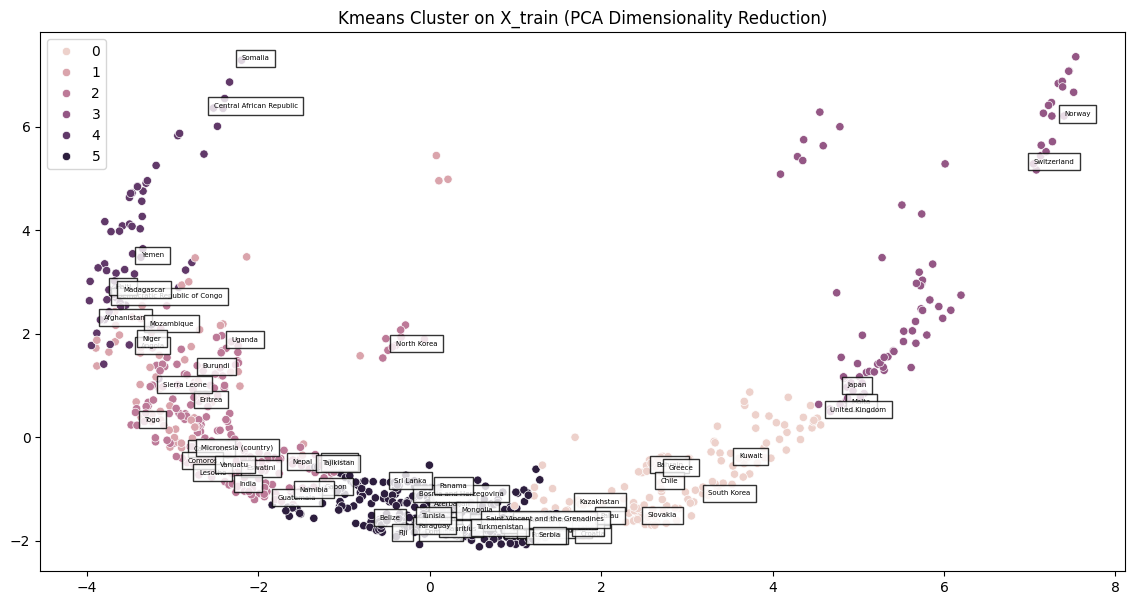

In [57]:
# ----------------------------------
# Visualize Cluster (PCA)
#-----------------------------------
df_imputed = pd.DataFrame(
    X_kmeans_imputed,
    columns=X_cl_train[num_variables].columns,  
    index=X_cl_train[num_variables].index      
)

X_cluster_pca = pd.concat([df_imputed, clusters_df], axis=1)
X_cluster_pca["Entity"] = X_cl_train["Entity"]
X_cluster_dist = X_cluster_pca[["kmeans_dist_0", "kmeans_dist_1", "kmeans_dist_2", "kmeans_dist_3", "kmeans_dist_4", "kmeans_dist_5"]]

clusters = X_cluster_dist.values.argmin(axis=1)

X_2d = PCA(n_components=2).fit_transform(X_cluster_dist)
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters)

n=14
for i, c in enumerate(X_cluster_pca["Entity"]):
    if i % n == 0:
        plt.text(X_2d[i, 0], X_2d[i, 1], c, fontsize=5, bbox=dict(facecolor="white", alpha=0.8))
plt.title("Kmeans Cluster on X_train (PCA Dimensionality Reduction)")
plt.show()

### Within Information - Realtive to Countries Mean

In [11]:
# ----------------------------------
# CustomTransfomer: 
# create new within country columns
# relative to mean: (num_col value) - (mean num_col value per country)
#-----------------------------------
class RelativeToCountryMean(BaseEstimator, TransformerMixin):
    def __init__(self, country_col, num_cols):
        self.country_col = country_col
        self.num_cols = num_cols
        #self.order_name = f"{num_cols}_order"
        
    def fit(self, X, y=None):
        self.means_ = X.groupby(self.country_col)[self.num_cols].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.num_cols:
            mean_col = X[self.country_col].map(self.means_[col])
            #X[col] = X[self.country_col].map(self.means_[col])
            #X[f"{col}_mean"] = mean_col
            X[f"{col}_within"] = X[col] - mean_col
            #X[col] = X[col].fillna(X[col].mean())
            #print(X[col].isna().sum())
        return X

    #def get_feature_names_out(self, input_features=None):  
    #    new_features = input_features if input_features is not None else self.feature_names_in_
    #    names = list(new_features)
    #    for col in self.num_cols:
    #        out_names.append(f"{col}_within")
    #    return np.array(names, dtype=object)

In [12]:
def ratio_health_gdp(X):
    X = X.copy()
    X["healthspending_gdp_ratio"] = X["annual_healthcare_expenditure_per_capita"] - X["gdp_per_capita_worldbank"]
    return X

ratio_feature = FunctionTransformer(ratio_health_gdp, validate=False, feature_names_out=lambda transformer, input_features: ["gdp_per_capita_worldbank", "annual_healthcare_expenditure_per_capita", "healthspending_gdp_ratio"])

### Preprocessing Pipeline

In [13]:
# ----------------------------------
# Preprocessing Pipeline Steps
#-----------------------------------

#impute & transform numeric columns
impute_transform = ColumnTransformer([
    ("log_nums", Pipeline([
        ("knn_impute", KNNImputer(n_neighbors=5, weights="distance")),
        ("log_transform", FunctionTransformer(np.log1p, feature_names_out="one-to-one"))
    ]), skewed_variables),
    
    ("powertransform_nums", Pipeline([
        ("knn_impute2", KNNImputer(n_neighbors=5, weights="distance")),
        ("powertransform", PowerTransformer(method="yeo-johnson"))
    ]), others),
    
    ("normal_dist_nums", Pipeline([
        ("knn_impute3", KNNImputer(n_neighbors=5, weights="distance")),
    ]), normal),

    #("health_gdp_ratio", Pipeline([
    #    ("health_gdp_ratio", ratio_feature),
    #]), [col_gdp, col_healthspending])
        
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform="pandas")

#ratio 
ratio_he_gdp = ColumnTransformer([
    ("health_gdp_ratio", Pipeline([
        ("health_gdp_ratio", ratio_feature),
    ]), [col_gdp, col_healthspending])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#one hot encode pipeline for categoric cols
categorical_cols = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

#Scale all num cols, ohe & drop country col
scale_ohe_step = ColumnTransformer([
    ("drop_nums", "drop", [col_gdp, col_healthspending]),
    ("scale_nums", RobustScaler(), rest_nums + ["healthspending_gdp_ratio"]),
    ("ohe_cat", categorical_cols, [col_regions, col_incomegroup]),
    ("drop_country", "drop", [col_country])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#combine steps for model pipeline
end_pipe = Pipeline([
    ("prep_nums", impute_transform),
    ("ratio_feature", ratio_he_gdp),
    #("ratio_feature", ratio),
    #("relative_to_mean", RelativeToCountryMean(
    #    country_col=col_country, 
    #    num_cols=all_numeric_cols
    #)),
    #("transf_nums", nums_transf),
    ("scale_ohe", scale_ohe_step),
    ("final_impute", KNNImputer(n_neighbors=5, weights="distance")),
])

gk = GroupKFold(n_splits=7)

### Linear Regression (Baseline)

In [16]:
from sklearn.model_selection import cross_validate
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", LinearRegression())
])

#Target is rightskewed, logtransform y before training
#lr_pipeline_y_log = TransformedTargetRegressor(
#    regressor=lr_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

lr_r2_cv = cross_val_score(lr_pipeline, X_train, y_train, groups=group_train, cv=gk, scoring="r2")
lr_mae_cv = cross_val_score(lr_pipeline, X_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline, X_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_r2_score = lr_r2_cv
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv
# print crossvalidations scores (splitted into gk-folds (5), fit on gk - 1 & evaluate on last fold > iterate 5times)
print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nR2:")
print(f"\nFolds R2 scores: {lr_r2_score}\nMean R2 Score: {round(lr_r2_score.mean(), 2)}\nStd R2: {round(lr_r2_score.std(), 2)}")
print("\nMAE:")
#print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {round(lr_mae_score.mean(), 2)}\nStd MAE: {round(lr_mae_score.std(), 2)}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {round(lr_rmse_score.mean(), 2)}\nStd RMSE: {round(lr_rmse_score.std(), 2)}\n")
print("-----------------------------------------\n")


lr_cv_results = cross_validate(
    estimator=lr_pipeline,
    X=X_train,
    y=y_train,
    groups=group_train,          
    cv=gk,
    scoring=metrics,
    return_train_score=True,
    return_estimator=True
)
print(f'Train r2 mean: {lr_cv_results["train_r2"].mean()}, Train mae mean: {-lr_cv_results["train_mae"].mean()}, Train rmse mean: {-lr_cv_results["train_rmse"].mean()}')


------LINEAR REGRESSION CV SCORES--------

R2:

Folds R2 scores: [0.63189981 0.82539709 0.56300479 0.56320962 0.67719891 0.80696826
 0.7944155 ]
Mean R2 Score: 0.69
Std R2: 0.11

MAE:

Folds MAE scores: [11.53669927  9.46115775 12.95709194 15.25982965 11.87826183 12.25118983
 14.23988304]
Mean MAE Score: 12.51
Std MAE: 1.75

RMSE:

Folds RMSE scores: [14.84119262 11.45974691 17.12871894 30.65536062 17.5435322  17.14602212
 20.15208019]
Mean RMSE Score: 18.42
Std RMSE: 5.58

-----------------------------------------

Train r2 mean: 0.7616956869941268, Train mae mean: 11.016531647828385, Train rmse mean: 17.38076112556219


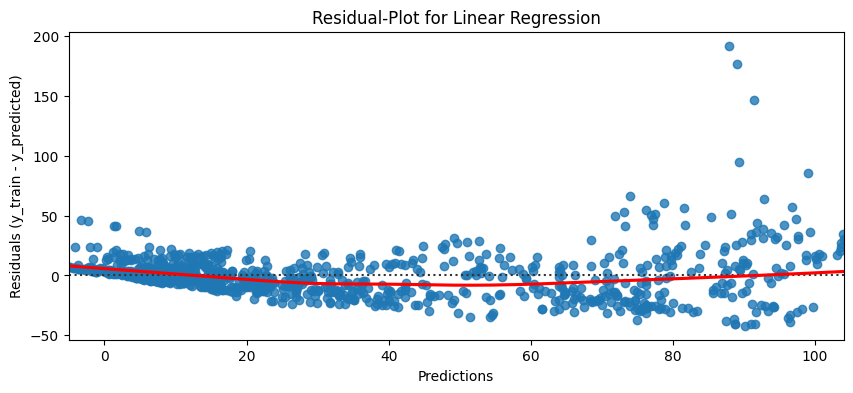

In [17]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline, X_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

#lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_train_norm, y_train_norm, groups=groups_train_norm, cv=gk)
#lr_residuals = y_train_norm - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

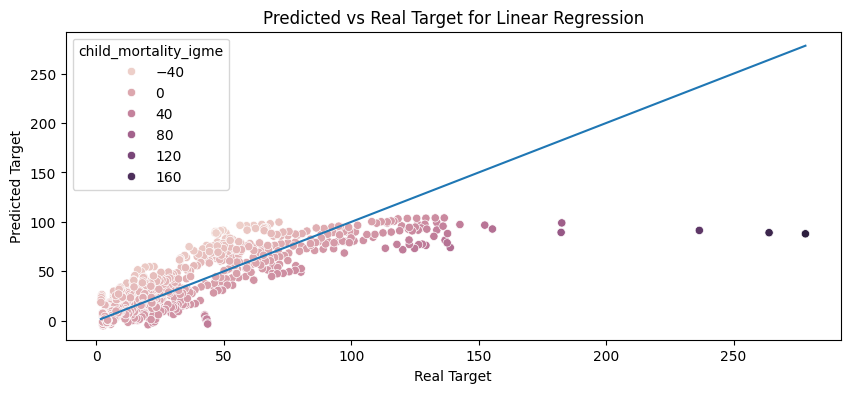

In [18]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")
#actual_vs_predicted(y_train_norm, lr_y_predicts, lr_residuals, "Linear Regression")

In [28]:
#print all feature columns
first_fitted_estimatorlr = lr_cv_results['estimator'][0]
#feature_pipelinelr = first_fitted_estimatorlr.regressor_
pre_pipelinelr = first_fitted_estimatorlr.named_steps['preprocess']
#last_transformerlr = pre_pipelinelr.steps[-1][1]
feature_names_finallr = pre_pipelinelr.get_feature_names_out()

print(f"Feature-Namen:")
print(feature_names_finallr)

Feature-Namen:
['nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'healthspending_gdp_ratio'
 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries'
 'world_income_group_missing']


#### Holdout Testset

In [30]:
lr_pipeline.fit(X_train, y_train)

holdout_test(lr_pipeline, X_test)  

----Holdout Testset: Final Metric Scores----
 MAE: 7.419847105481969, R2: 0.7938723792371395, RMSE: 10.268514021031033
[ 5.2687542   9.69444654 16.67666492 20.83350403]


### Ridge

In [32]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL (RIDGE)
#--------------------------------------------------
ridge_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", Ridge())
])

#Target is rightskewed, logtransform y before training
#ridge_pipeline_y_log  = TransformedTargetRegressor(
#    regressor=ridge_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 30, 40]
}
# fit trainset via GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
ridge_grid.fit(X_train, y_train, groups=group_train)
best_ridge_model = ridge_grid.best_estimator_
# print metrics scores
show_scores(ridge_grid, "Ridge")
ridge_grid.best_estimator_


------Ridge CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.76), np.float64(0.74), np.float64(0.76), np.float64(0.8), np.float64(0.76), np.float64(0.74), np.float64(0.73)]
            
Mean Train R2 Score: 0.76
            
Test Folds R2 Scores: [np.float64(0.65), np.float64(0.85), np.float64(0.66), np.float64(0.56), np.float64(0.69), np.float64(0.81), np.float64(0.79)]
            
Mean Test R2 Score (best_score_): 0.72)   
            
Std Test R2 Score: 0.1

MAE:

Train Folds MAE Scores: [np.float64(11.03), np.float64(11.62), np.float64(11.26), np.float64(10.16), np.float64(11.06), np.float64(10.92), np.float64(10.53)]
            
Mean Train MAE Score: 10.94
            
Test Folds MAE Scores: [np.float64(11.29), np.float64(8.59), np.float64(12.06), np.float64(15.6), np.float64(11.24), np.float64(11.44), np.float64(13.81)]
            
Mean Test MAE Score: 12.0
            
Std Test MAE Score: 2.04

RMSE:

Train Folds RMSE Scores: [np.float64(18.26), np.float64(18.64)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                                                                  ('ohe_cat',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['world_regions_wb',
                                                                    'world_income_group']),
                                                                  ('drop_country',
                                                                   'drop',
                                                                   ['Entity'])],
                                                    verbose_feature_names_out=False)),
                                 ('final_impute',
                                  KNNImputer(weights='distance'))])),
                ('model', Ridge(alpha=40))])

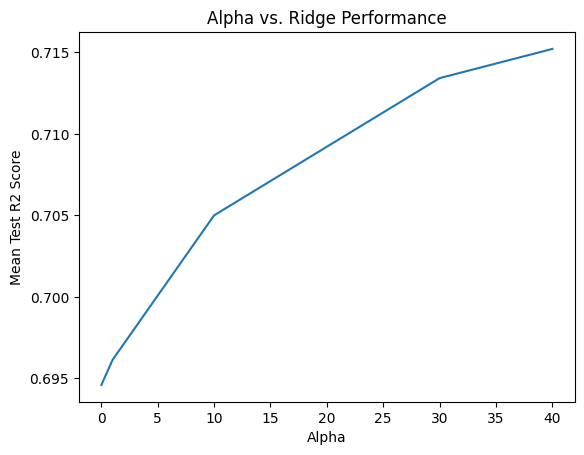

In [35]:
#show lineplot - best alpha - r2 score
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
sns.lineplot(x=ridge_results['param_model__alpha'], y=ridge_results['mean_test_r2'])
plt.title("Alpha vs. Ridge Performance")
plt.xlabel("Alpha")
plt.ylabel("Mean Test R2 Score")
plt.show()

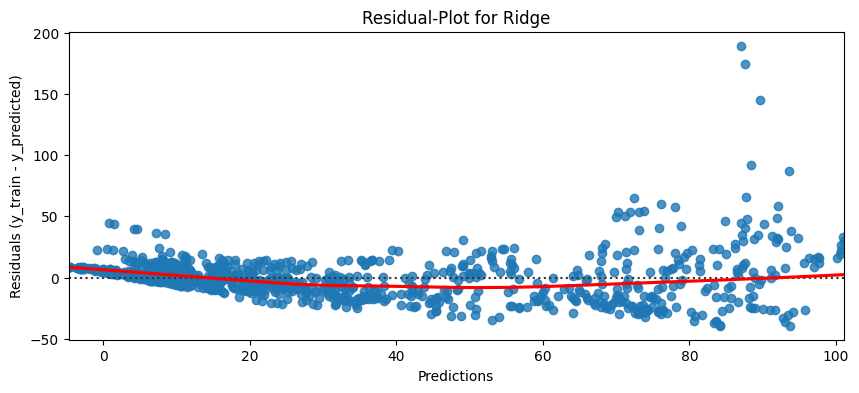

In [36]:
ridge_y_predicts = cross_val_predict(best_ridge_model, X_train, y_train, groups=group_train, cv=gk)
ridge_residuals = y_train - ridge_y_predicts

residual_plot(ridge_y_predicts, ridge_residuals, "Ridge")

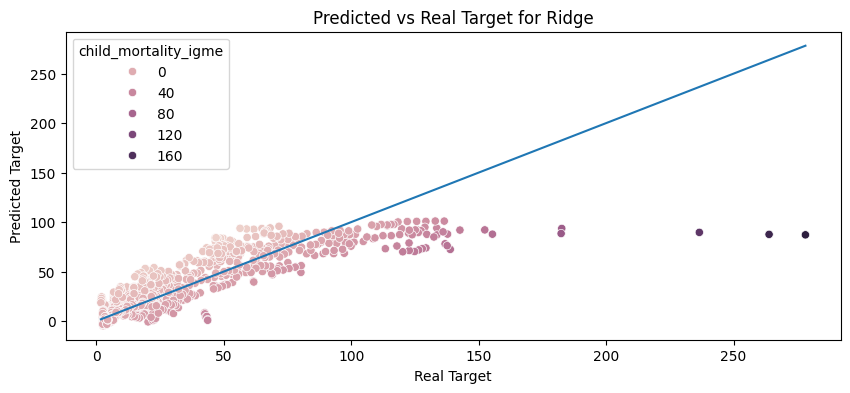

In [37]:
actual_vs_predicted(y_train, ridge_y_predicts, ridge_residuals, "Ridge")

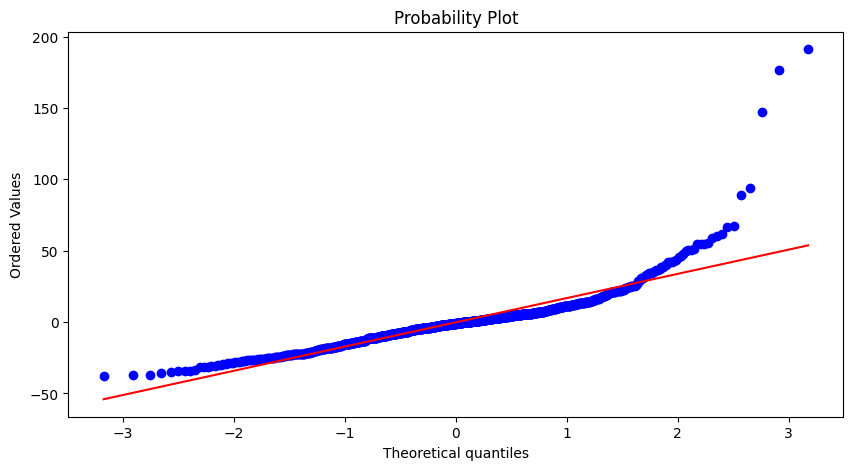

In [38]:
#prob. plot: shows heavy tails
prob_plot(ridge_residuals)

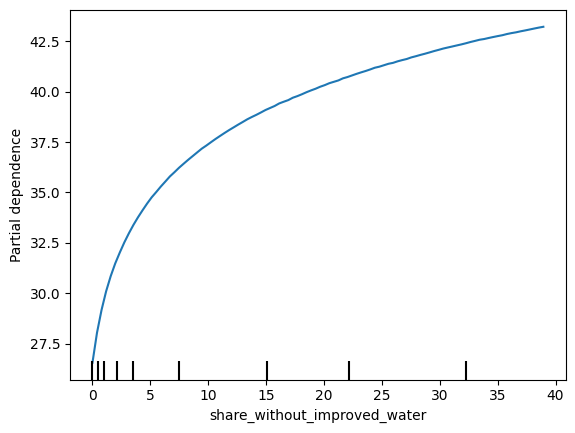

In [39]:
from sklearn.inspection import PartialDependenceDisplay
#prediction decreases when gdp_per_capita increases
#prediction decreases when vaccination_coverage increases
PartialDependenceDisplay.from_estimator(best_ridge_model, X_train, ["share_without_improved_water"])

#### Holdout Testset

In [40]:
#best_ridge_model.fit(X_train, y_train)

holdout_test(best_ridge_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 7.089018362740561, R2: 0.8077260621064318, RMSE: 9.917443061143835
[ 4.93806465  9.61681796 17.25753501 20.25434341]


In [44]:
ridge_feature_pipeline = best_ridge_model
pre_pipeline_ridge = ridge_feature_pipeline.named_steps['preprocess']
#last_transformer_ridge = pre_pipeline_ridge.steps[-1][1]
feature_names_final_ridge = pre_pipeline_ridge.get_feature_names_out()

In [45]:
pi_result_ridge = permutation_importance(best_ridge_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df_ridge = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_ridge.importances_mean, 4),
    'importance_std': np.round(pi_result_ridge.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_ridge

feature  importance_mean  importance_std
8            vaccination_coverage_who_unicef           0.1704          0.0133
10                          world_regions_wb           0.1626          0.0319
7               share_without_improved_water           0.1115          0.0158
9                         years_of_schooling           0.0693          0.0165
1   annual_healthcare_expenditure_per_capita           0.0601          0.0109
11                        world_income_group           0.0205          0.0063
2                   gdp_per_capita_worldbank           0.0196          0.0058
3        nurses_and_midwives_per_1000_people           0.0139          0.0066
6                  share_of_population_urban           0.0093          0.0025
4                 physicians_per_1000_people           0.0008          0.0013
0                                     Entity           0.0000          0.0000
5             prevalence_of_undernourishment          -0.0050          0.0047

### ElasticNet

In [46]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL ELASTICNET
#--------------------------------------------------
elasticnet_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", ElasticNet(max_iter=5000, random_state=99))
])
#Target is rightskewed, logtransform y before training
#elasticnet_pipeline_y_log = TransformedTargetRegressor(
#    regressor=elasticnet_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

elasticnet_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 30, 60, 90],
    "model__l1_ratio": [0.1, 0.2, 0.5, 0.8]
}

elasticnet_grid = GridSearchCV(elasticnet_pipeline, elasticnet_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
elasticnet_grid.fit(X_train, y_train, groups=group_train)
best_elasticnet_model = elasticnet_grid.best_estimator_

show_scores(elasticnet_grid, "ElasticNet")

elasticnet_grid.best_estimator_
#pd.DataFrame(elasticnet_grid.cv_results_)


------ElasticNet CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.75), np.float64(0.73), np.float64(0.75), np.float64(0.8), np.float64(0.75), np.float64(0.73), np.float64(0.73)]
            
Mean Train R2 Score: 0.75
            
Test Folds R2 Scores: [np.float64(0.65), np.float64(0.85), np.float64(0.69), np.float64(0.55), np.float64(0.68), np.float64(0.81), np.float64(0.78)]
            
Mean Test R2 Score (best_score_): 0.72)   
            
Std Test R2 Score: 0.1

MAE:

Train Folds MAE Scores: [np.float64(11.12), np.float64(11.65), np.float64(11.3), np.float64(10.22), np.float64(11.02), np.float64(10.94), np.float64(10.61)]
            
Mean Train MAE Score: 10.98
            
Test Folds MAE Scores: [np.float64(11.16), np.float64(8.31), np.float64(11.73), np.float64(16.02), np.float64(11.23), np.float64(11.45), np.float64(13.69)]
            
Mean Test MAE Score: 11.94
            
Std Test MAE Score: 2.21

RMSE:

Train Folds RMSE Scores: [np.float64(18.52), np.float64(

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['world_regions_wb',
                                                                    'world_income_group']),
                                                                  ('drop_country',
                                                                   'drop',
                                                                   ['Entity'])],
                                                    verbose_feature_names_out=False)),
                                 ('final_impute',
                                  KNNImputer(weights='distance'))])),
                ('model',
                 ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=5000,
                            random_state=99))])

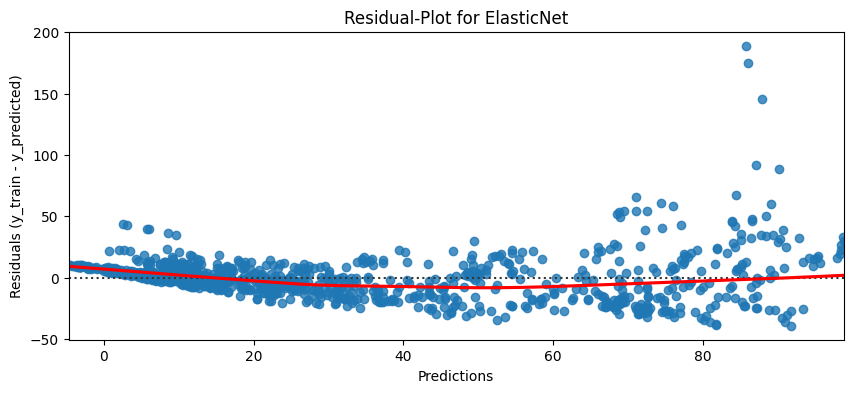

In [47]:
# -------------------------------------------------
# RESIDUAL PLOT FOR ELASTICNET
#--------------------------------------------------
elasticnet_y_predicts = cross_val_predict(best_elasticnet_model, X_train, y_train, groups=group_train, cv=gk)
elasticnet_residuals = y_train - elasticnet_y_predicts

residual_plot(elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

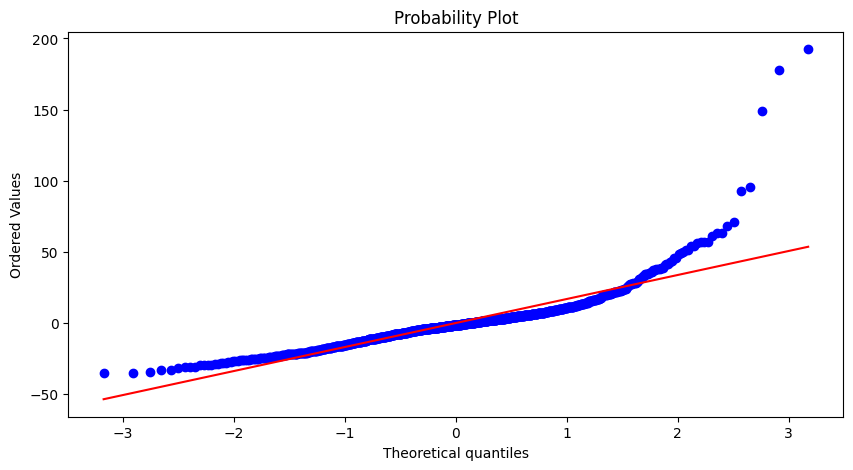

In [48]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR ELASTICNET 
#--------------------------------------------------
prob_plot(elasticnet_residuals)

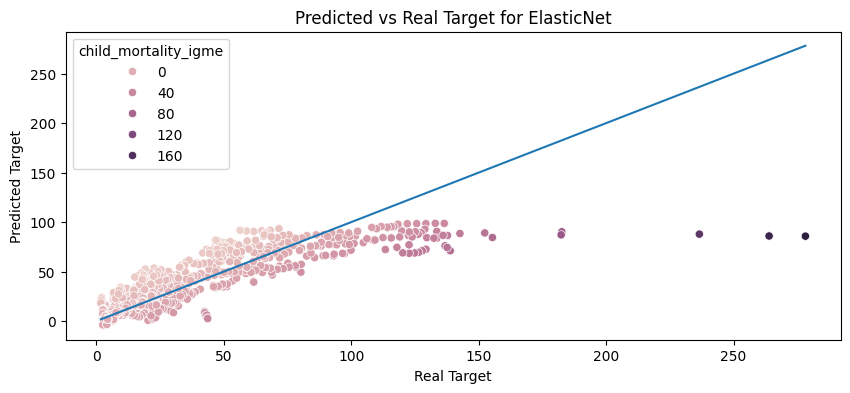

In [49]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR ELASTUCNET
#--------------------------------------------------
#actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")
actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

In [50]:
pi_result_el = permutation_importance(best_elasticnet_model, X_test, y_test, n_repeats=40, random_state=42)
importance_df_el = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_el.importances_mean, 4),
    'importance_std': np.round(pi_result_el.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_el

feature  importance_mean  importance_std
8            vaccination_coverage_who_unicef           0.1431          0.0209
10                          world_regions_wb           0.1368          0.0178
7               share_without_improved_water           0.0922          0.0135
1   annual_healthcare_expenditure_per_capita           0.0644          0.0120
9                         years_of_schooling           0.0623          0.0123
11                        world_income_group           0.0243          0.0062
2                   gdp_per_capita_worldbank           0.0234          0.0070
3        nurses_and_midwives_per_1000_people           0.0193          0.0077
6                  share_of_population_urban           0.0079          0.0035
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0003          0.0014
5             prevalence_of_undernourishment          -0.0055          0.0036

#### Holdout Test

In [51]:
#best_elasticnet_model.fit(X_train, y_train)

holdout_test(best_elasticnet_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 7.2954318574171895, R2: 0.807172495654078, RMSE: 9.931709211924943
[ 4.81281794 10.06399777 16.9401351  20.10644497]


### Random Forest

In [53]:
# -------------------------------------------------
# RF
#--------------------------------------------------
rf_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", RandomForestRegressor(random_state=99))
])
#Target is rightskewed, logtransform y before training
#rf_pipeline_y_log = TransformedTargetRegressor(
#    regressor=rf_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

rf_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [1, 3],
    "model__min_samples_split": [5, 15],
    "model__min_samples_leaf": [20, 30],
    "model__max_features": [0.2],
    "model__max_samples": [0.7, 0.8]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
rf_grid.fit(X_train, y_train, groups=group_train)
best_rf_model = rf_grid.best_estimator_

show_scores(rf_grid, "RF")
rf_grid.best_estimator_


------RF CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.79), np.float64(0.75), np.float64(0.78), np.float64(0.82), np.float64(0.8), np.float64(0.76), np.float64(0.76)]
            
Mean Train R2 Score: 0.78
            
Test Folds R2 Scores: [np.float64(0.57), np.float64(0.87), np.float64(0.81), np.float64(0.51), np.float64(0.69), np.float64(0.83), np.float64(0.78)]
            
Mean Test R2 Score (best_score_): 0.72)   
            
Std Test R2 Score: 0.13

MAE:

Train Folds MAE Scores: [np.float64(9.88), np.float64(10.98), np.float64(10.43), np.float64(9.49), np.float64(9.09), np.float64(10.17), np.float64(9.64)]
            
Mean Train MAE Score: 9.95
            
Test Folds MAE Scores: [np.float64(12.13), np.float64(8.12), np.float64(8.85), np.float64(16.95), np.float64(11.85), np.float64(10.65), np.float64(13.44)]
            
Mean Test MAE Score: 11.71
            
Std Test MAE Score: 2.75

RMSE:

Train Folds RMSE Scores: [np.float64(16.86), np.float64(18.26), np.f

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['world_regions_wb',
                                                                    'world_income_group']),
                                                                  ('drop_country',
                                                                   'drop',
                                                                   ['Entity'])],
                                                    verbose_feature_names_out=False)),
                                 ('final_impute',
                                  KNNImputer(weights='distance'))])),
                ('model',
                 RandomForestRegressor(max_depth=3, max_features=0.2,
                                       max_samples=0.8, min_samples_leaf=20,
                                       min_samples_split=5, n_estimators=500,
                                       random_state=99))])

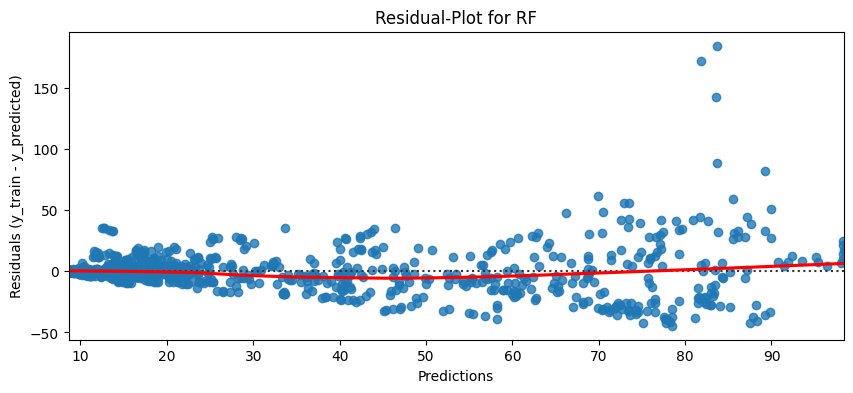

In [54]:
rf_y_predicts = cross_val_predict(best_rf_model, X_train, y_train, groups=group_train, cv=gk)
rf_residuals = y_train - rf_y_predicts

residual_plot(rf_y_predicts, rf_residuals, "RF")

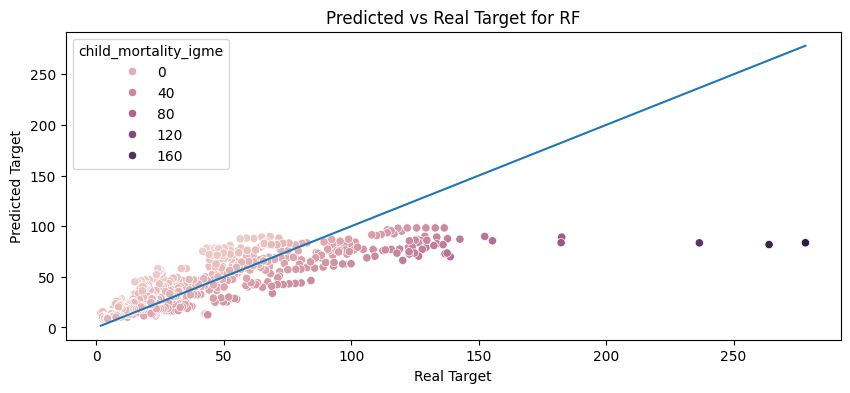

In [55]:
actual_vs_predicted(y_train, rf_y_predicts, rf_residuals, "RF")

In [56]:
rf_feature_pipeline = best_rf_model
pre_pipeline = rf_feature_pipeline.named_steps['preprocess']
#last_transformer = pre_pipeline.steps[-1][1]
feature_names_final = pre_pipeline.get_feature_names_out()
print("Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:")
print(feature_names_final)

Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:
['nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'healthspending_gdp_ratio'
 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries'
 'world_income_group_missing']


In [57]:
###Holdout Testset
#best_rf_model.fit(X_train, y_train)

holdout_test(best_rf_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 7.160901299738066, R2: 0.8599981012071214, RMSE: 8.46265172590061
[ 6.22465081  8.38217543 13.09067716 16.62786457]


### XGBoost

In [59]:
# -------------------------------------------------
# XGBOOST
#--------------------------------------------------
xgb_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42))
])
#Target is rightskewed, logtransform y before training
#xgb_pipeline_y_log = TransformedTargetRegressor(
#    regressor=xgb_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

xgb_param_grid = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [3, 5],
    "model__min_child_weight": [1, 5],
    "model__subsample": [0.8, 1.0],
    "model__reg_alpha": [0.01, 0.1]
}

xgb_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=gk, scoring=metrics, refit="mae", n_jobs=-1, return_train_score=True)

xgb_search.fit(X_train, y_train, groups=group_train)

show_scores(xgb_search, "XGB")

best_xgb_model = xgb_search.best_estimator_
best_xgb_model


------XGB CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.95), np.float64(0.95), np.float64(0.94), np.float64(0.96), np.float64(0.95), np.float64(0.94), np.float64(0.95)]
            
Mean Train R2 Score: 0.95
            
Test Folds R2 Scores: [np.float64(0.58), np.float64(0.83), np.float64(0.85), np.float64(0.61), np.float64(0.63), np.float64(0.88), np.float64(0.89)]
            
Mean Test R2 Score (best_score_): 0.75)   
            
Std Test R2 Score: 0.13

MAE:

Train Folds MAE Scores: [np.float64(5.23), np.float64(5.42), np.float64(5.36), np.float64(4.51), np.float64(4.85), np.float64(5.43), np.float64(5.0)]
            
Mean Train MAE Score: 5.11
            
Test Folds MAE Scores: [np.float64(11.3), np.float64(7.33), np.float64(6.97), np.float64(15.68), np.float64(12.17), np.float64(9.02), np.float64(9.88)]
            
Mean Test MAE Score: 10.34
            
Std Test MAE Score: 2.81

RMSE:

Train Folds RMSE Scores: [np.float64(8.51), np.float64(8.49), np.float64(

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              n_estimators=400, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=42, ...))])

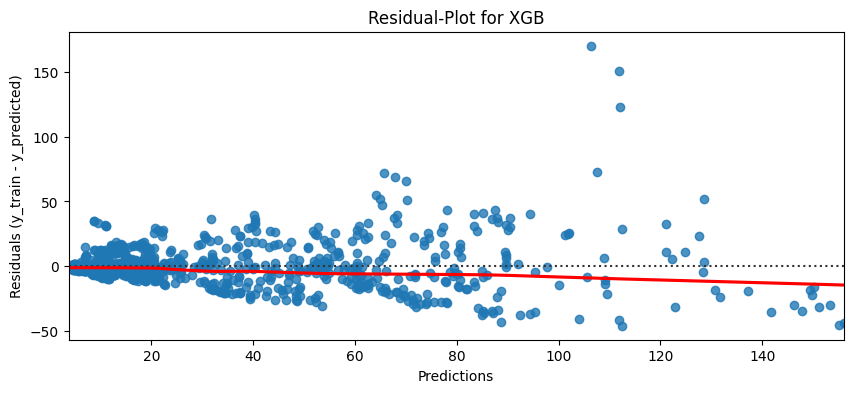

In [60]:
xgb_y_predicts = cross_val_predict(best_xgb_model, X_train, y_train, groups=group_train, cv=gk)
xgb_residuals = y_train - xgb_y_predicts

residual_plot(xgb_y_predicts, xgb_residuals, "XGB")

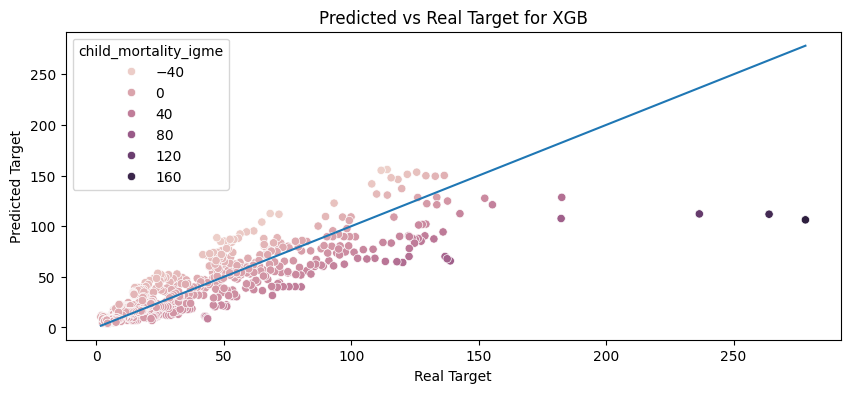

In [61]:
actual_vs_predicted(y_train, xgb_y_predicts, xgb_residuals, "XGB")

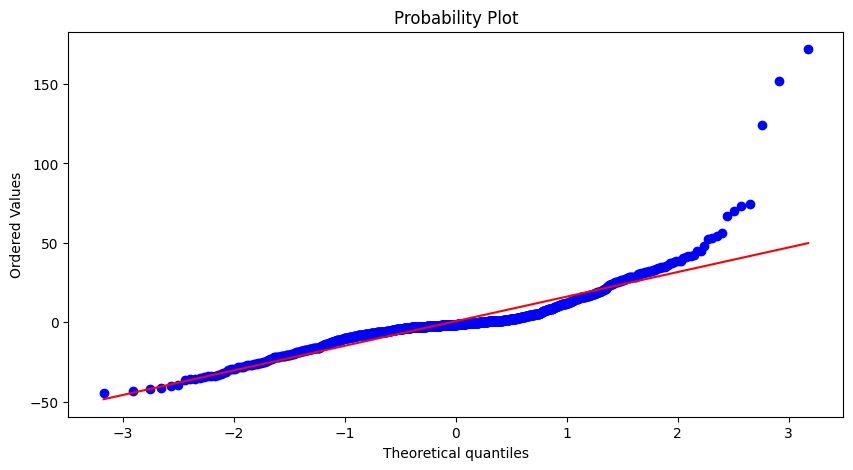

In [62]:
prob_plot(xgb_residuals)

#### Holdout Testset

In [67]:
#Holdout Testset
#best_xgb_model.fit(X_train, y_train)

holdout_test(best_xgb_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 5.299497715420637, R2: 0.89116427852233, RMSE: 7.461484403260112
[ 3.26039427  7.30241732 13.75037441 16.6821811 ]


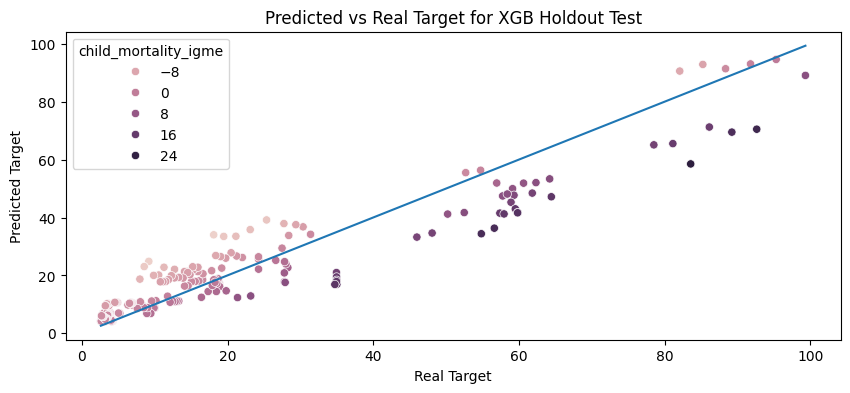

In [70]:
xgb_y_test_predicts = best_xgb_model.predict(X_test)
xgb_test_residuals = y_test - xgb_y_test_predicts

actual_vs_predicted(y_test, xgb_y_test_predicts, xgb_test_residuals, "XGB Holdout Test")

### Extremes (Quantile)

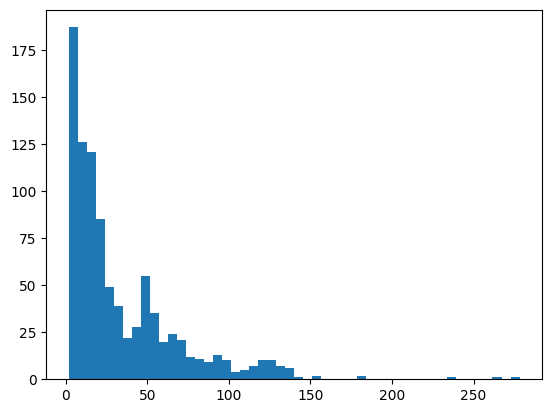

In [517]:
plt.hist(y_train, bins=50)
plt.show()

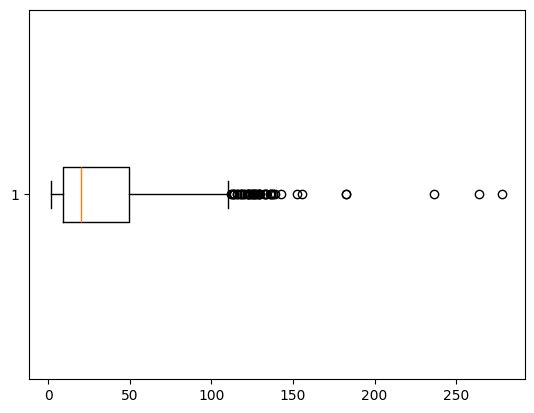

In [518]:
plt.boxplot(y_train, vert=False)
plt.show()

In [42]:
for q in [0.5, 0.70, 0.95]:
    print(f"{q*100:.0f}% Quant:", np.quantile(y_train, q))

qu = 0.95
threshold = np.quantile(y_train, qu)
n_extreme = (y_train > threshold).sum()
print("\nExtremes num:", n_extreme)

50% Quant: 20.0529625
70% Quant: 44.26989699999999
95% Quant: 113.22383799999992

Extremes num: 47


In [579]:
q50 = np.quantile(y_train, 0.5)
print("50%-Quantil (Median):", q50)

50%-Quantil (Median): 20.0529625


In [580]:
n_above_q50 = (y_train > q50).sum()
n_below_q50 = (y_train <= q50).sum()
print("Anzahl über q50:", n_above_q50)
print("Anzahl unter q50:", n_below_q50)

Anzahl über q50: 462
Anzahl unter q50: 462


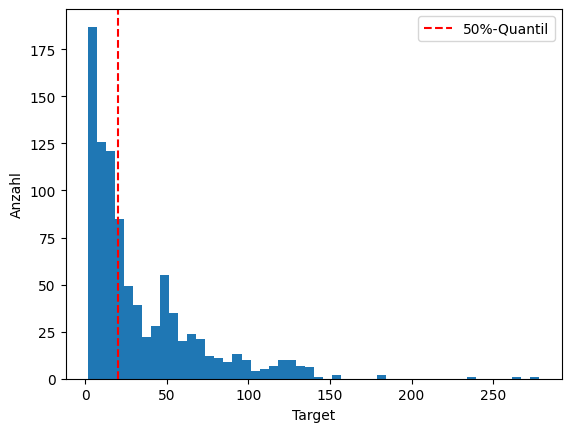

In [581]:
plt.hist(y_train, bins=50)
plt.axvline(q50, color='red', linestyle='--', label='50%-Quantil')
plt.xlabel("Target")
plt.ylabel("Anzahl")
plt.legend()
plt.show()

### Quantile Regression with GradientBoostingRegressor

In [72]:
# -------------------------------------------------
# GradientBoostingRegressor
#--------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor

def pinball_score(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

gb_quantiles = [0.25, 0.5, 0.75]
gb_models = {}
gb_cv_results = {}


gb_param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [2, 4],
    "model__learning_rate": [0.01, 0.05, 0.1]
}

for q in gb_quantiles:
    print(f"Train for {q}")
    
    gb_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", GradientBoostingRegressor(loss="quantile",alpha=q,random_state=99))
    ])

    #gb_pipeline_y_log  = TransformedTargetRegressor(
    #    regressor=gb_pipeline,
    #    func=np.log1p,
    #    inverse_func=np.expm1
    #)

    # fit trainset via GridSearchCV
    gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=gk, scoring=pinball_score(q), return_train_score=True, n_jobs=-1)
    gb_grid.fit(X_train, y_train, groups=group_train)

    gb_models[q] = gb_grid.best_estimator_
    #gb_models[q]
    print("Best params:", gb_grid.best_params_)
    #gb_results = pd.DataFrame(gb_grid.cv_results_)

Train for 0.25
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200}
Train for 0.5
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}
Train for 0.75
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 200}


Coverage: 0.32792207792207795
Above diagonal: 0.672077922077922
Below diagonal: 0.32792207792207795

Trainset: Quantile 0.25, Pinball Loss: 3.5477

mean=3.5477, std=0.8261
MAE: 11.1507, std=2.86597172913054 R2: 0.6650, std=0.1247

Coverage: 0.5681818181818182
Above diagonal: 0.4318181818181818
Below diagonal: 0.5681818181818182

Trainset: Quantile 0.5, Pinball Loss: 5.1354

mean=5.1354, std=1.3206
MAE: 10.2708, std=2.641245914601161 R2: 0.7564, std=0.1199

Coverage: 0.6785714285714286
Above diagonal: 0.32142857142857145
Below diagonal: 0.6785714285714286

Trainset: Quantile 0.75, Pinball Loss: 4.9814

mean=4.9814, std=1.6291
MAE: 11.3494, std=2.7204855539649526 R2: 0.7379, std=0.1505



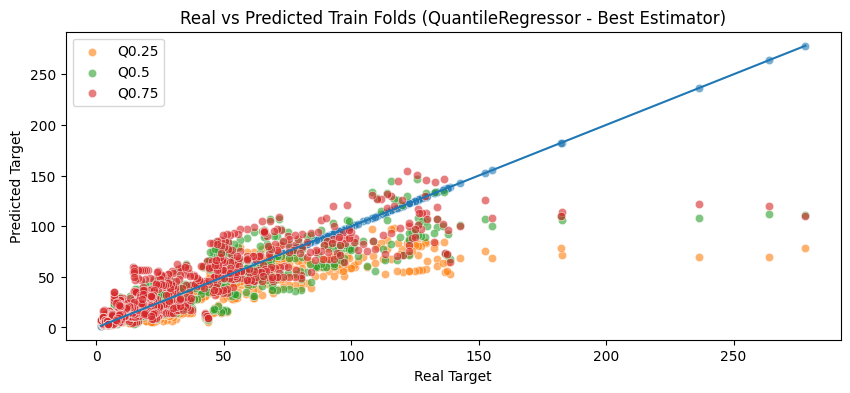

In [73]:
gb_y_pred_train = {}  
gb_residuals = {}
#Residuals & pinball mean losses
for q, model in gb_models.items():
    gb_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    gb_residuals[q] = y_train - gb_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= gb_y_pred_train[q]))
    print("Above diagonal:", np.mean(y_train > gb_y_pred_train[q]))
    print("Below diagonal:", np.mean(y_train < gb_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, gb_y_pred_train[q], alpha=q)
    print(f"\nTrainset: Quantile {q}, Pinball Loss: {loss:.4f}\n")

    #pinball score + std
    gb_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)
    gb_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring=gb_scorer)
    print(f"mean={-gb_scores.mean():.4f}, std={gb_scores.std():.4f}")
    #mae + r2 Zusatz
    gb_mae_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="neg_mean_absolute_error")
    gb_r2_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="r2")
    print(f"MAE: {-gb_mae_scores.mean():.4f}, std={gb_mae_scores.std()} R2: {gb_r2_scores.mean():.4f}, std={gb_r2_scores.std():.4f}\n")

#Real vs Predicted Scatterplots
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in gb_quantiles:
    sns.scatterplot(x=y_train, y=gb_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Real vs Predicted Train Folds (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

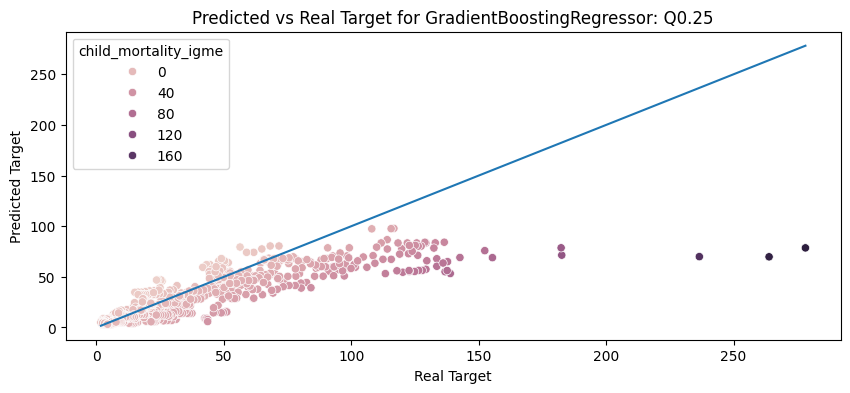

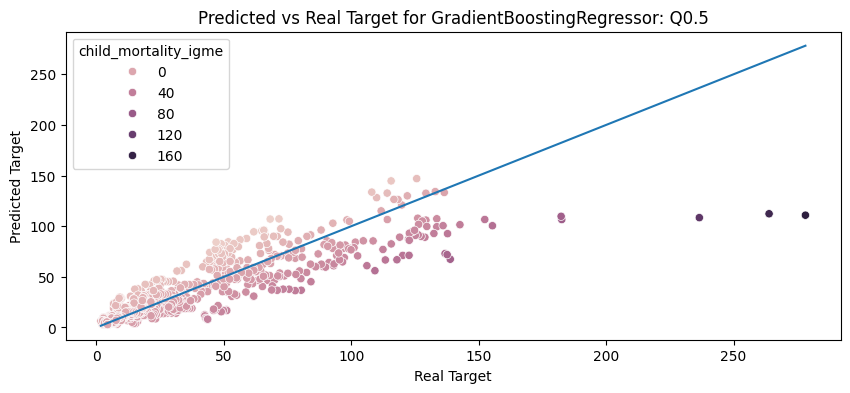

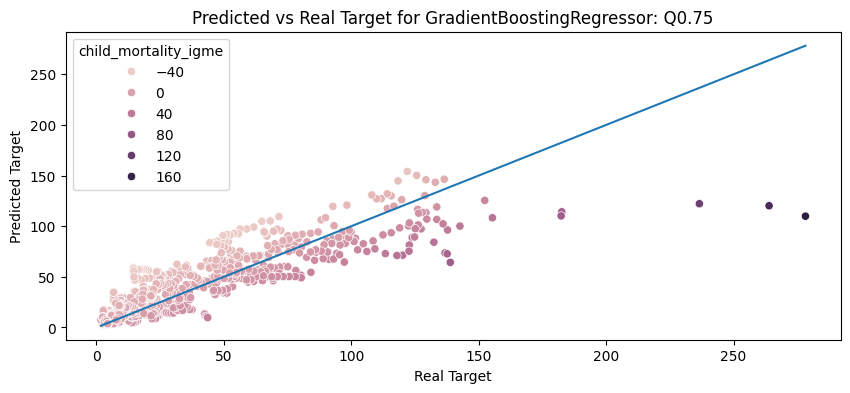

In [74]:
actual_vs_predicted(y_train, gb_y_pred_train[0.25], gb_residuals[0.25], f"GradientBoostingRegressor: Q{0.25}")
actual_vs_predicted(y_train, gb_y_pred_train[0.5], gb_residuals[0.5], f"GradientBoostingRegressor: Q{0.5}")
actual_vs_predicted(y_train, gb_y_pred_train[0.75], gb_residuals[0.75], f"GradientBoostingRegressor: Q{0.75}")

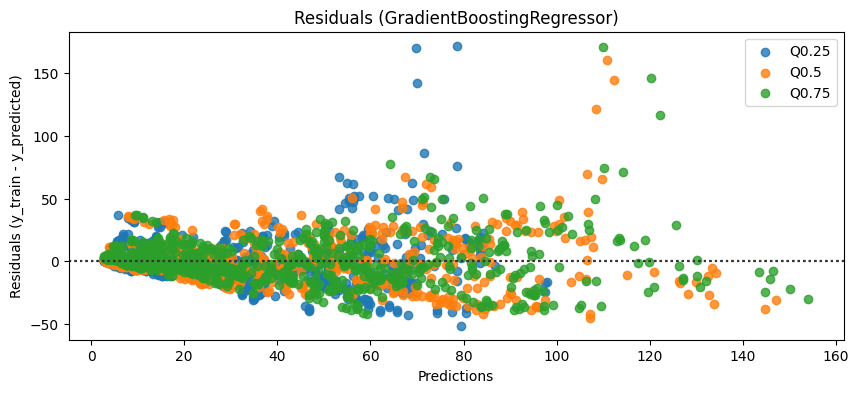

In [75]:
plt.figure(figsize=(10,4))
for q in gb_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=gb_y_pred_train[q], y=gb_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (GradientBoostingRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

#### Holdout Test

In [79]:
gb_y_pred_test = {}
gb_test_residuals = {}
for q, model in gb_models.items():
    #model.fit(X_train, y_train)
    #holdout_test(model, X_test)
    gb_y_pred_test[q] = model.predict(X_test)

    gb_test_residuals[q] = y_test - gb_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= gb_y_pred_test[q]))
    print("Above:", np.mean(y_test > gb_y_pred_test[q]))
    print("Below:", np.mean(y_test < gb_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, gb_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, gb_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.42735042735042733
Above: 0.5726495726495726
Below: 0.42735042735042733

Quantile 0.25, Pinball Loss: 2.4623

Coverage: 0.6111111111111112
Above: 0.3888888888888889
Below: 0.6111111111111112

Quantile 0.5, Pinball Loss: 2.9000

Coverage: 0.7393162393162394
Above: 0.2606837606837607
Below: 0.7393162393162394

Quantile 0.75, Pinball Loss: 2.3809


Q0.5 MAE: 5.800009343543808


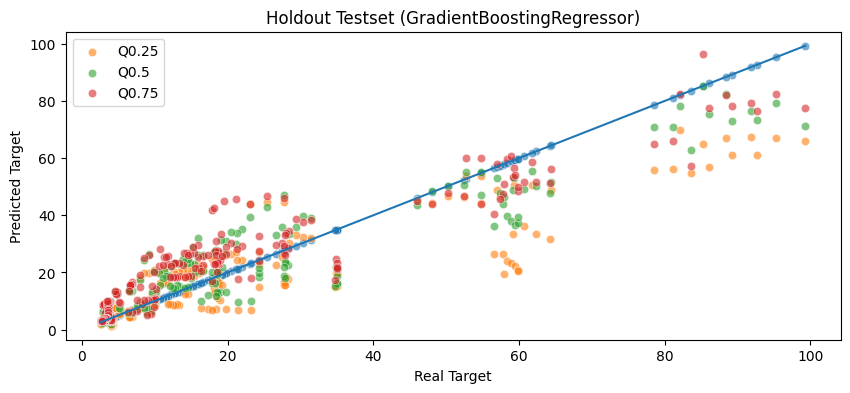

In [77]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in gb_quantiles:
    sns.scatterplot(x=y_test, y=gb_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (GradientBoostingRegressor)")
plt.legend()
plt.show()

### Quantile Regression with QuantileRegressor

In [105]:
# -------------------------------------------------
# QuantileRegressor
#--------------------------------------------------
#https://xgboosting.com/xgboost-prediction-interval-using-quantile-regression/
from sklearn.linear_model import QuantileRegressor
from joblib import dump, load

qr_quantiles = [0.25, 0.5, 0.75]
qr_models = {}
cv_results = {}

def pinball_scoring(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

qr_param_grid = {
    #"regressor__model__alpha": [0.01, 0.05, 0.1, 0.5, 1]
    "model__alpha": [0.01, 0.05, 0.1, 0.5, 1]
}

for q in qr_quantiles:
    print(f"Train for {q}")
    
    qr_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", QuantileRegressor(quantile=q))
    ])

    #qr_pipeline_y_log = TransformedTargetRegressor(
    #    regressor=qr_pipeline,
    #    func=np.log1p,
    #    inverse_func=np.expm1
    #)

    # fit trainset via GridSearchCV
    qr_grid = GridSearchCV(qr_pipeline, qr_param_grid, cv=gk, scoring=pinball_scoring(q), return_train_score=True, n_jobs=-1)
    qr_grid.fit(X_train, y_train, groups=group_train)

    qr_models[q] = qr_grid.best_estimator_
    print("Best params:", qr_grid.best_params_)
#qr_grid.best_estimator_
    #gb_results = pd.DataFrame(gb_grid.cv_results_)
    #print(gb_results[["params", "mean_test_score", "rank_test_score"]])

Train for 0.25
Best params: {'model__alpha': 0.01}
Train for 0.5
Best params: {'model__alpha': 0.01}
Train for 0.75
Best params: {'model__alpha': 0.01}


#### Train Folds Performance per Q

Coverage: 0.2846320346320346
Above: 0.7153679653679653
Below: 0.2846320346320346

Folds CV: Quantile 0.25, Folds Mean Pinball Loss: 3.9430
mean=3.9430, std=0.7144
MAE: 13.0233, std=3.118991016641248 R2: 0.5691, std=0.1185

Coverage: 0.5140692640692641
Above: 0.48593073593073594
Below: 0.5140692640692641

Folds CV: Quantile 0.5, Folds Mean Pinball Loss: 5.8936
mean=5.8936, std=1.3165
MAE: 11.7872, std=2.6330315565294513 R2: 0.6938, std=0.1019

Coverage: 0.7229437229437229
Above: 0.27705627705627706
Below: 0.7229437229437229

Folds CV: Quantile 0.75, Folds Mean Pinball Loss: 5.1406
mean=5.1406, std=1.5184
MAE: 13.6338, std=2.803255107189965 R2: 0.6521, std=0.1525



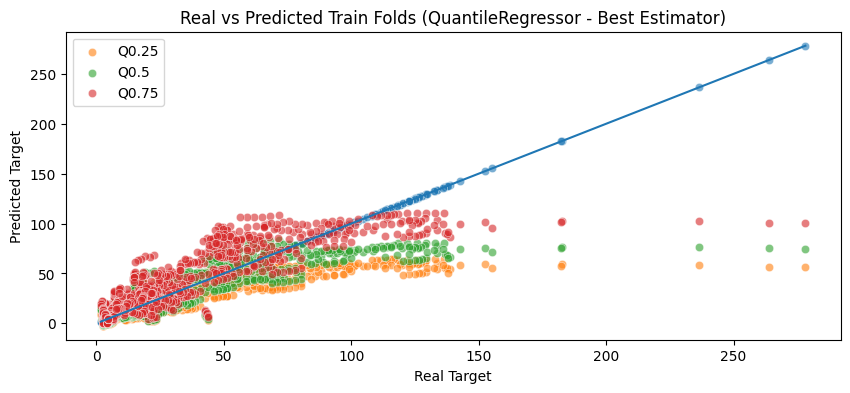

In [106]:
#qr_y_training_pred= {}

qr_y_pred_train = {}  
qr_residuals = {}
#Residuals & pinball mean losses
for q, model in qr_models.items():
    qr_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    qr_residuals[q] = y_train - qr_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= qr_y_pred_train[q]))
    print("Above:", np.mean(y_train > qr_y_pred_train[q]))
    print("Below:", np.mean(y_train < qr_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, qr_y_pred_train[q], alpha=q)
    print(f"\nFolds CV: Quantile {q}, Folds Mean Pinball Loss: {loss:.4f}")

    #pinball score + std
    qr_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)
    qr_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring=qr_scorer)
    print(f"mean={-qr_scores.mean():.4f}, std={qr_scores.std():.4f}")
    #mae + r2 Zusatz
    qr_mae_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="neg_mean_absolute_error")
    qr_r2_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="r2")
    print(f"MAE: {-qr_mae_scores.mean():.4f}, std={qr_mae_scores.std()} R2: {qr_r2_scores.mean():.4f}, std={qr_r2_scores.std():.4f}\n")
    #print("Fold MAE Scores": qr_mae_scores)

#Real vs Predicted Scatterplots
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_train, y=qr_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Real vs Predicted Train Folds (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

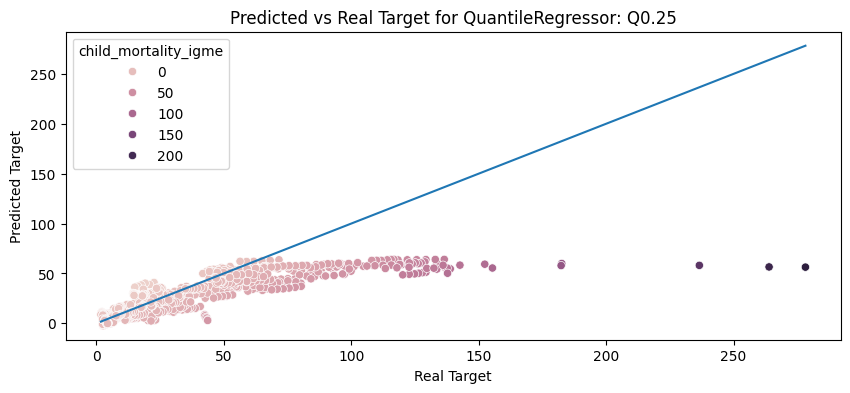

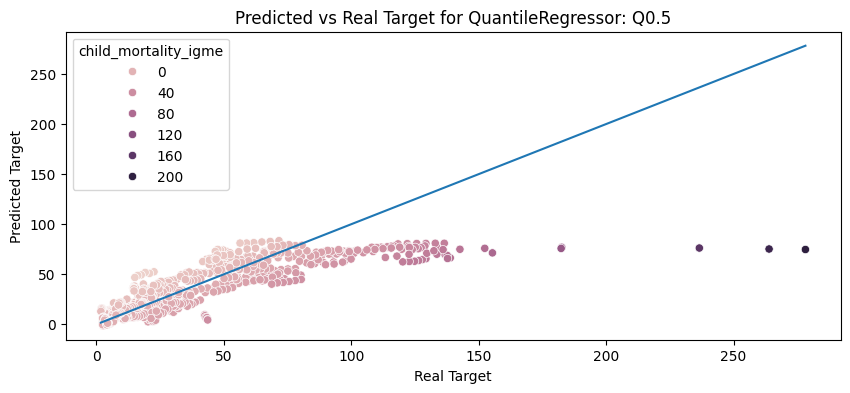

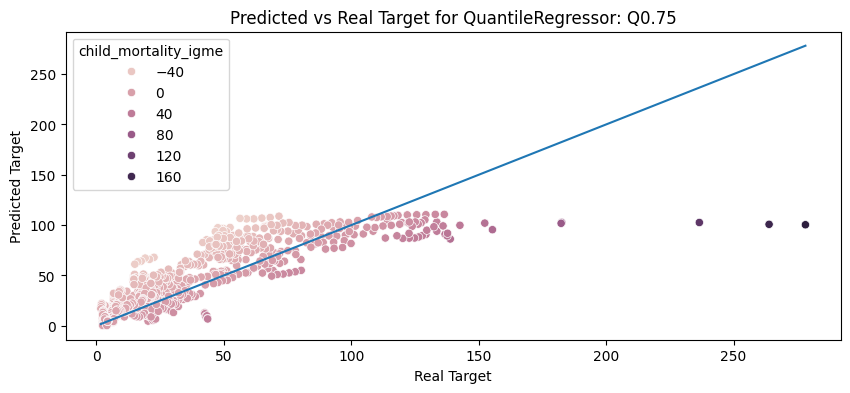

In [107]:
actual_vs_predicted(y_train, qr_y_pred_train[0.25], qr_residuals[0.25], f"QuantileRegressor: Q{0.25}")
actual_vs_predicted(y_train, qr_y_pred_train[0.5], qr_residuals[0.5], f"QuantileRegressor: Q{0.5}")
actual_vs_predicted(y_train, qr_y_pred_train[0.75], qr_residuals[0.75], f"QuantileRegressor: Q{0.75}")

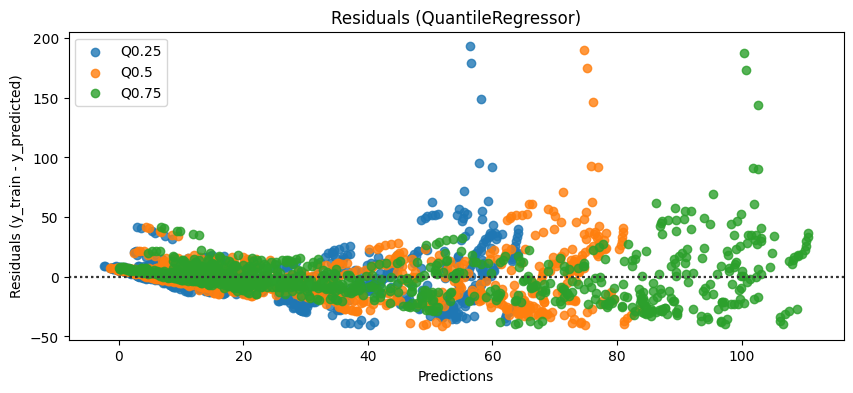

In [108]:
plt.figure(figsize=(10,4))
for q in qr_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=qr_y_pred_train[q], y=qr_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (QuantileRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

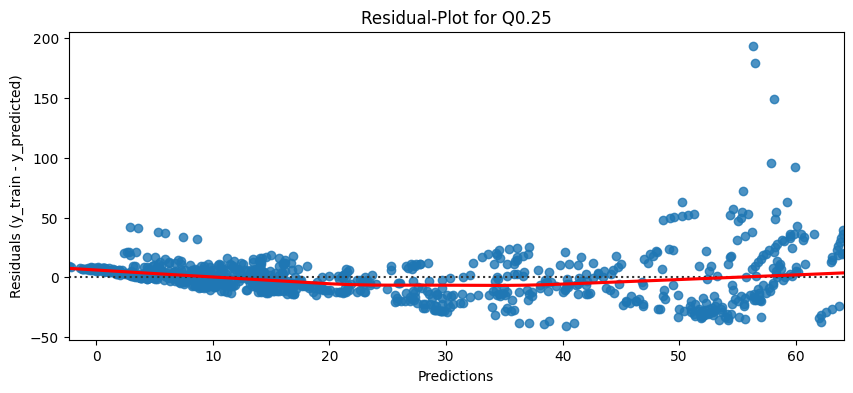

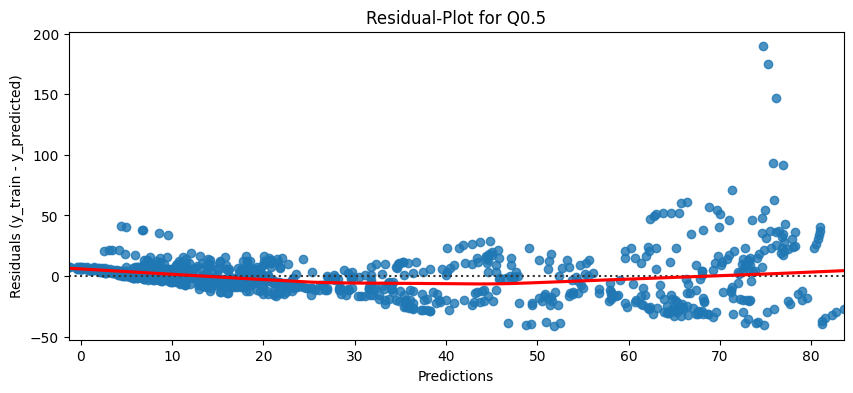

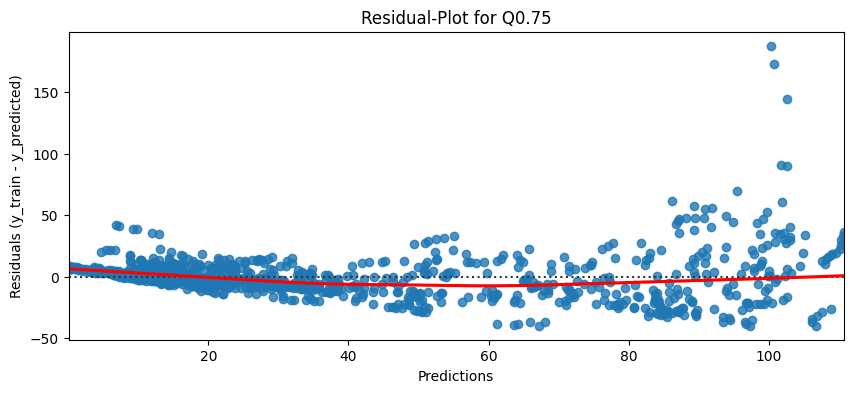

In [110]:
residual_plot(qr_y_pred_train[0.25], qr_residuals[0.25], f"Q{0.25}")
residual_plot(qr_y_pred_train[0.5], qr_residuals[0.5], f"Q{0.5}")
residual_plot(qr_y_pred_train[0.75], qr_residuals[0.75], f"Q{0.75}")

In [85]:
qr_results = pd.DataFrame(qr_grid.cv_results_)
qr_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.431448      0.013929         0.066204        0.008979   
1       0.357365      0.046713         0.090640        0.022728   
2       0.311755      0.043344         0.069232        0.010996   
3       0.290680      0.015638         0.059488        0.006169   
4       0.261111      0.032793         0.061399        0.005848   

   param_model__alpha                  params  split0_test_score  \
0                0.01  {'model__alpha': 0.01}          -4.791180   
1                0.05  {'model__alpha': 0.05}          -4.575496   
2                0.10   {'model__alpha': 0.1}          -5.122393   
3                0.50   {'model__alpha': 0.5}          -9.298203   
4                1.00     {'model__alpha': 1}          -9.298203   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          -2.743821          -4.092950          -7.633394          -5.136248   
1          -3.243436          -3.280677          -8.526610          -6.325600   
2          -4.532492          -3.956566          -9.552497          -7.744212   
3         -10.369287          -9.883739         -15.027138         -11.154322   
4         -10.369287          -9.883739         -15.027138         -11.154322   

   split5_test_score  split6_test_score  mean_test_score  std_test_score  \
0          -4.766278          -6.820236        -5.140587        1.518437   
1          -6.043234          -7.772917        -5.681139        1.925236   
2          -7.899293          -9.299538        -6.872427        2.135692   
3         -14.913829         -17.536202       -12.597531        2.950953   
4         -14.913829         -17.536202       -12.597531        2.950953   

   rank_test_score  split0_train_score  split1_train_score  \
0                1           -4.665772           -4.989703   
1                2           -5.208676           -5.533186   
2                3           -6.426899           -6.811959   
3                4          -13.112660          -12.937227   
4                4          -13.112660          -12.937227   

   split2_train_score  split3_train_score  split4_train_score  \
0           -4.777318           -4.235709           -4.610241   
1           -5.422417           -4.893989           -5.250841   
2           -6.761879           -5.839074           -6.373386   
3          -13.019619          -12.159697          -12.803253   
4          -13.019619          -12.159697          -12.803253   

   split5_train_score  split6_train_score  mean_train_score  std_train_score  
0           -4.701018           -4.430766         -4.630075         0.224551  
1           -5.339386           -4.998533         -5.235290         0.209791  
2           -6.553122           -6.088798         -6.407874         0.324389  
3          -12.176122          -11.743616        -12.564599         0.491658  
4          -12.176122          -11.743616        -12.564599         0.491658

#### SHAP Explanations

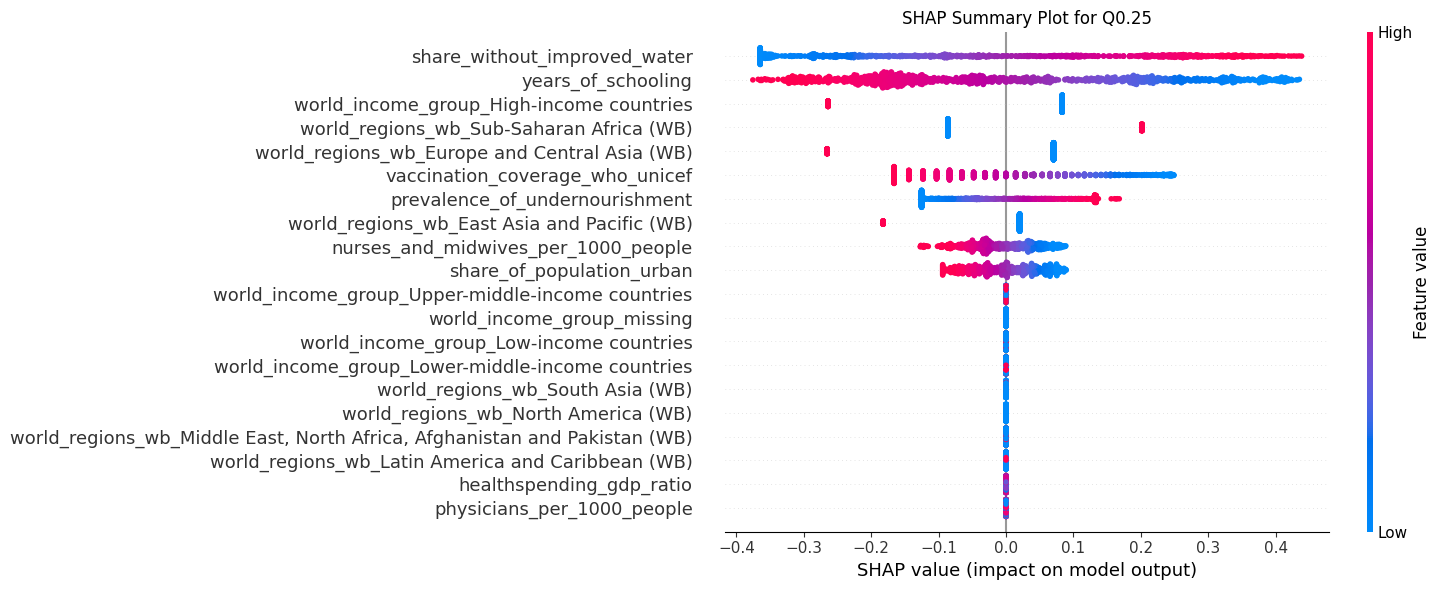

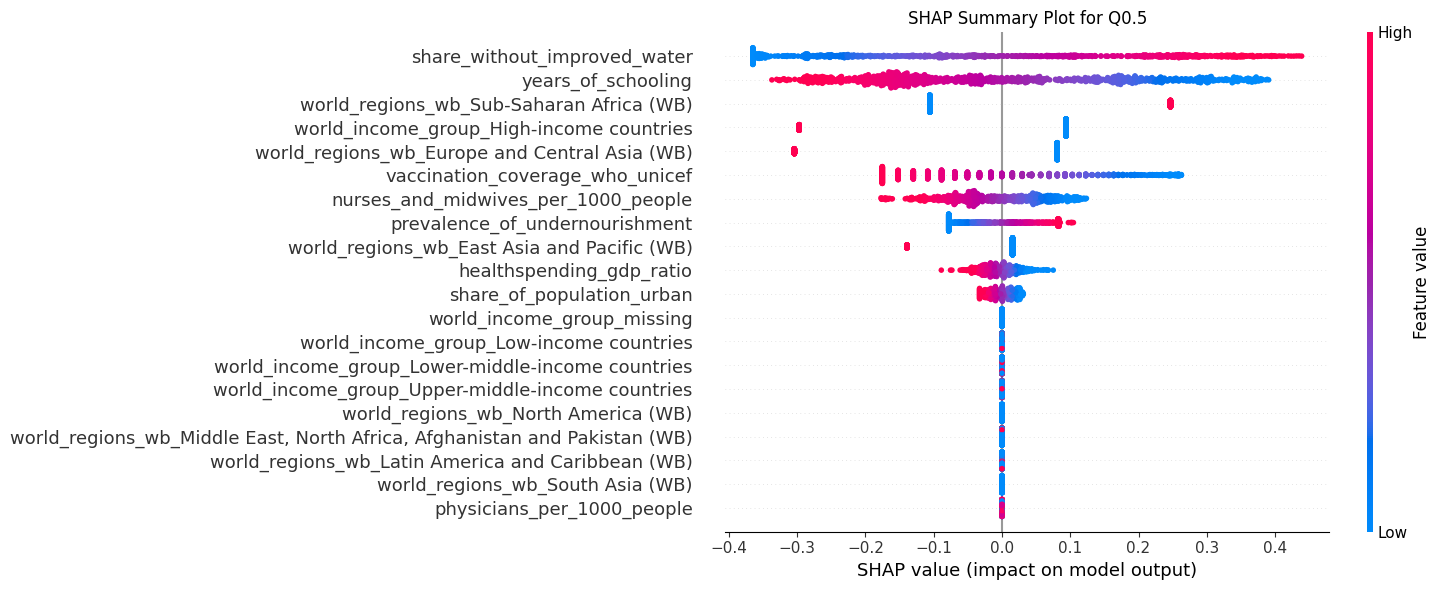

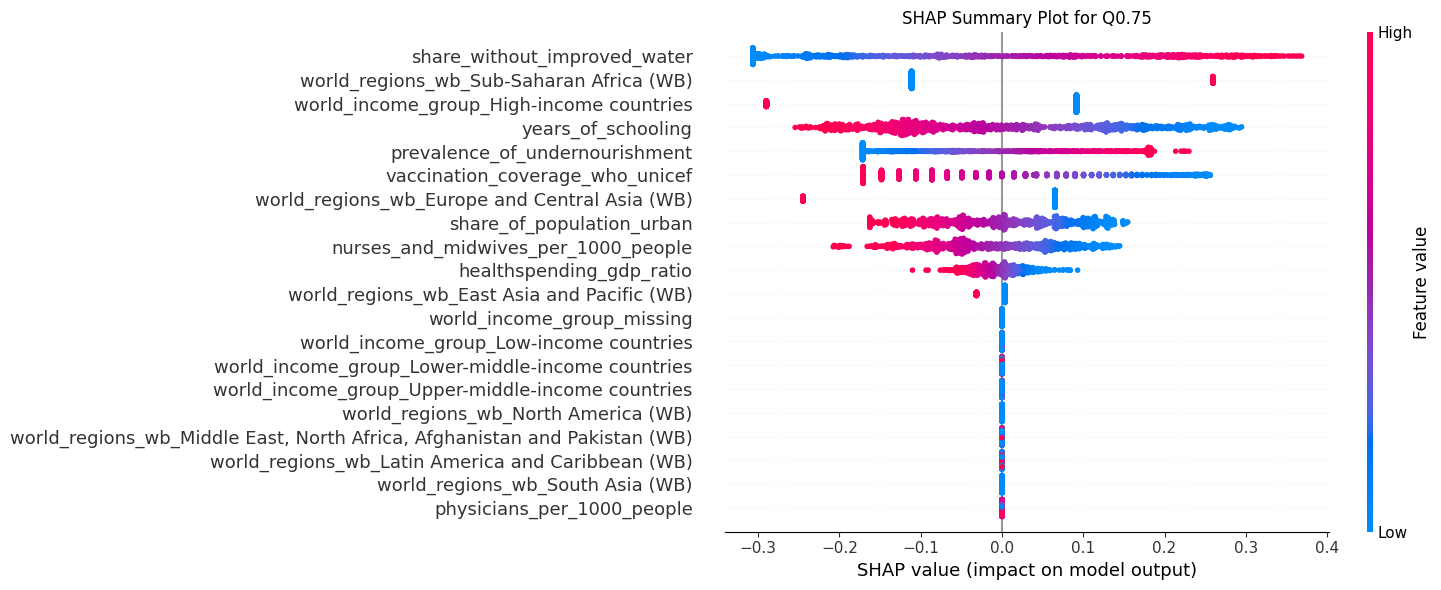

In [80]:
import shap
rng = np.random.default_rng(seed=42)

for q, model in qr_models.items():
    qr_pipeline = model.regressor_
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    X_qr_transf = qr_pre.transform(X_train)
    X_qr_features = qr_pre.get_feature_names_out()

    expl = shap.Explainer(qr_model, X_qr_transf)
    shapvals = expl(X_qr_transf)
    shapvals.feature_names = list(X_qr_features)
    
    plt.title(f"SHAP Summary Plot for Q{q}")
    shap.summary_plot(shapvals, X_qr_transf, feature_names=X_qr_features, rng=rng, plot_size=[15,6],  max_display=25)
    #shap.plots.waterfall(shapvals[0]) #first sample observation

    #shap.plots.waterfall(shap_vals[0])
    #shap.dependence_plot("share_without_improved_water", shapvals, X_qr_transf)
    plt.show()

#### Holdout Testset

In [111]:
qr_y_pred_test = {}
qr_test_residuals = {}
for q, model in qr_models.items():
    #model.fit(X_train, y_train)
    #holdout_test(model, X_test)
    qr_y_pred_test[q] = model.predict(X_test)

    qr_test_residuals[q] = y_test - qr_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= qr_y_pred_test[q]))
    print("Above:", np.mean(y_test > qr_y_pred_test[q]))
    print("Below:", np.mean(y_test < qr_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, qr_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, qr_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.29914529914529914
Above: 0.7008547008547008
Below: 0.29914529914529914

Quantile 0.25, Pinball Loss: 2.5490

Coverage: 0.5213675213675214
Above: 0.47863247863247865
Below: 0.5213675213675214

Quantile 0.5, Pinball Loss: 3.2558

Coverage: 0.7948717948717948
Above: 0.20512820512820512
Below: 0.7948717948717948

Quantile 0.75, Pinball Loss: 2.9201


Q0.5 MAE: 6.5115320952240445


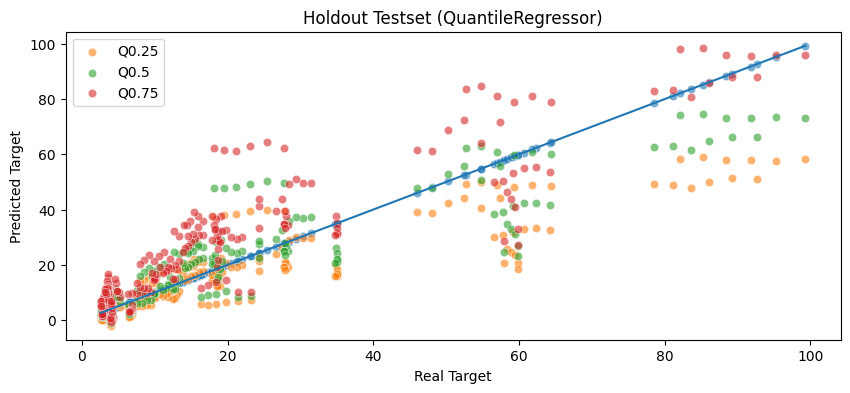

In [112]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_test, y=qr_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (QuantileRegressor)")
plt.legend()
plt.show()

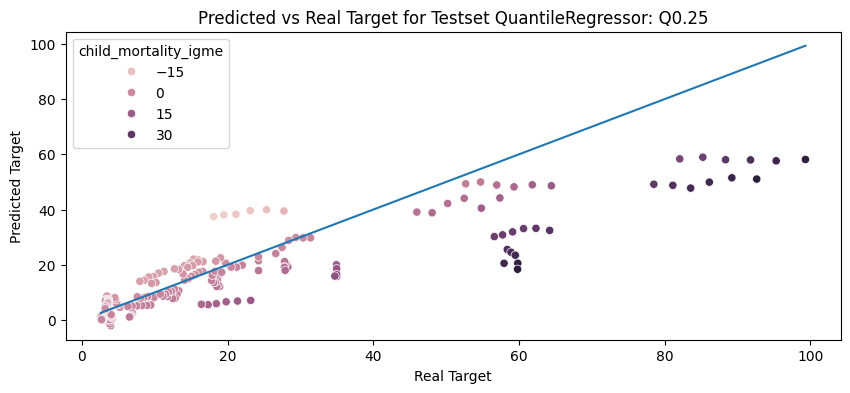

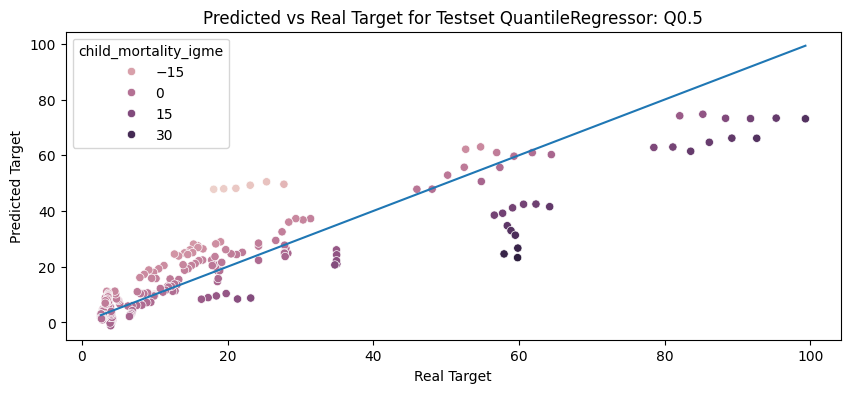

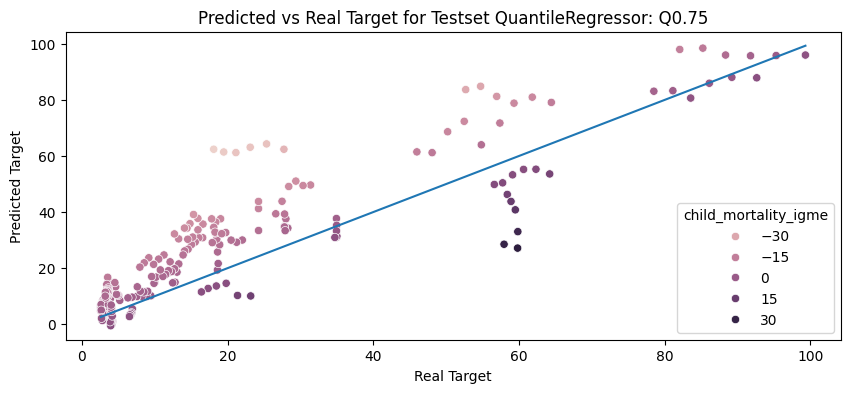

In [113]:
actual_vs_predicted(y_test, qr_y_pred_test[0.25], qr_test_residuals[0.25], f"Testset QuantileRegressor: Q{0.25}")
actual_vs_predicted(y_test, qr_y_pred_test[0.5], qr_test_residuals[0.5], f"Testset QuantileRegressor: Q{0.5}")
actual_vs_predicted(y_test, qr_y_pred_test[0.75], qr_test_residuals[0.75], f"Testset QuantileRegressor: Q{0.75}")

In [134]:
#Test new data sample 
bangladesh_new = [{'Entity': 'Bangladesh', 'annual_healthcare_expenditure_per_capita': 120, 'gdp_per_capita_worldbank': 3000, 'nurses_and_midwives_per_1000_people': 10.5, 'physicians_per_1000_people': 0.5, 'prevalence_of_undernourishment': 20.8, 'share_of_population_urban': 16, 'share_without_improved_water': 80.2, 'vaccination_coverage_who_unicef': 98, 'years_of_schooling': 2, 'world_regions_wb': 'South Asia (WB)', 'world_income_group': 'Lower-middle-income countries'}]
bangladesh_df = pd.DataFrame(bangladesh_new)

In [135]:
qr_y_pred_test_bang = {}
qr_test_residuals_bang = {}
for q, model in qr_models.items():

    qr_y_pred_test_bang[q] = model.predict(bangladesh_df)
print(qr_y_pred_test_bang)


{0.25: array([43.52937209]), 0.5: array([47.7911293]), 0.75: array([57.08634841])}


In [136]:
qr_y_pred_test_bang[0.25]

array([43.52937209])

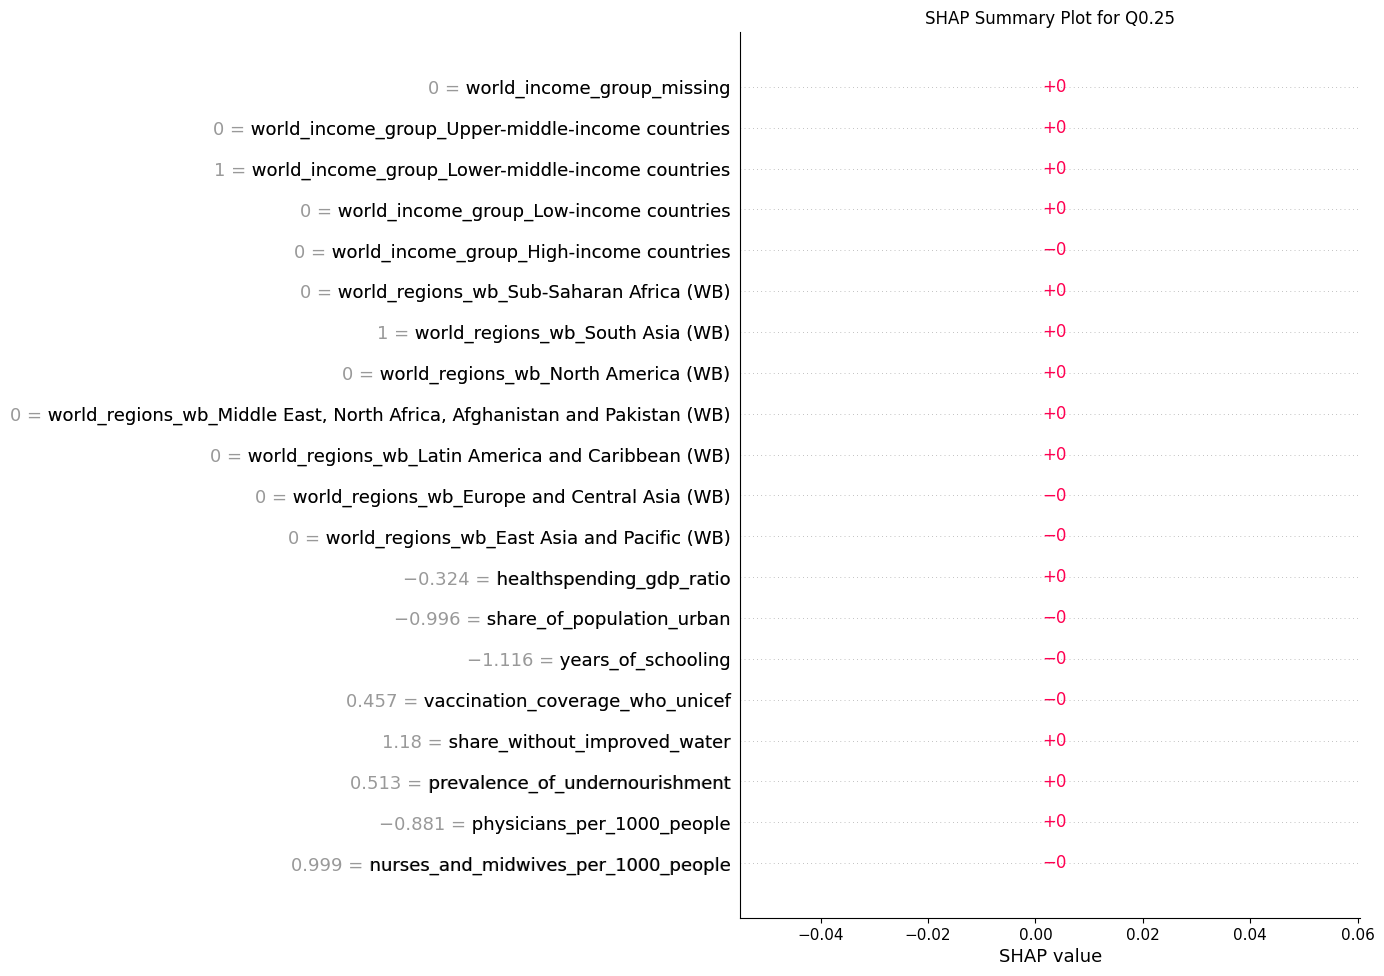

In [ ]:
for q, model in qr_models.items():
    qr_pipeline = model.regressor_
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    X_qr_transf = qr_pre.transform(bangladesh_df)
    X_qr_features = qr_pre.get_feature_names_out()

    expl = shap.Explainer(qr_model, X_qr_transf)
    shapvals = expl(X_qr_transf)
    shapvals.feature_names = list(X_qr_features)
    
    plt.title(f"SHAP Summary Plot for Q{q}")
    #shap.summary_plot(shapvals, X_qr_transf, feature_names=X_qr_features, rng=rng, plot_size=[15,6],  max_display=25)
    shap.plots.bar(shapvals[0], max_display=20) #first sample observation

    #shap.plots.waterfall(shap_vals[0])
    #shap.dependence_plot("share_without_improved_water", shapvals, X_qr_transf)
    plt.show()

#### Permutation Importance

In [122]:
pi_result_qr = permutation_importance(qr_models[0.75], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr.importances_mean, 4),
    'importance_std': np.round(pi_result_qr.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr

feature  importance_mean  importance_std
10                          world_regions_wb           0.2349          0.0309
8            vaccination_coverage_who_unicef           0.1229          0.0195
7               share_without_improved_water           0.0429          0.0113
9                         years_of_schooling           0.0408          0.0142
2                   gdp_per_capita_worldbank           0.0286          0.0049
6                  share_of_population_urban           0.0023          0.0032
11                        world_income_group           0.0019          0.0054
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0000          0.0007
1   annual_healthcare_expenditure_per_capita          -0.0019          0.0070
3        nurses_and_midwives_per_1000_people          -0.0102          0.0046
5             prevalence_of_undernourishment          -0.0145          0.0030

In [123]:
pi_result_qr5 = permutation_importance(qr_models[0.5], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr5 = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr5.importances_mean, 4),
    'importance_std': np.round(pi_result_qr5.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr5

feature  importance_mean  importance_std
10                          world_regions_wb           0.2278          0.0251
7               share_without_improved_water           0.1229          0.0141
9                         years_of_schooling           0.1212          0.0167
8            vaccination_coverage_who_unicef           0.0939          0.0124
11                        world_income_group           0.0158          0.0029
3        nurses_and_midwives_per_1000_people           0.0089          0.0024
6                  share_of_population_urban           0.0082          0.0023
1   annual_healthcare_expenditure_per_capita           0.0018          0.0009
5             prevalence_of_undernourishment           0.0005          0.0026
2                   gdp_per_capita_worldbank           0.0003          0.0002
4                 physicians_per_1000_people           0.0002          0.0001
0                                     Entity           0.0000          0.0000

In [124]:
pi_result_qr25 = permutation_importance(qr_models[0.25], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr25 = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr25.importances_mean, 4),
    'importance_std': np.round(pi_result_qr25.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr25

feature  importance_mean  importance_std
10                          world_regions_wb           0.1994          0.0212
7               share_without_improved_water           0.1579          0.0160
9                         years_of_schooling           0.1518          0.0180
8            vaccination_coverage_who_unicef           0.0716          0.0094
11                        world_income_group           0.0171          0.0025
1   annual_healthcare_expenditure_per_capita           0.0112          0.0016
5             prevalence_of_undernourishment           0.0080          0.0031
6                  share_of_population_urban           0.0050          0.0012
4                 physicians_per_1000_people           0.0042          0.0009
0                                     Entity           0.0000          0.0000
3        nurses_and_midwives_per_1000_people          -0.0000          0.0000
2                   gdp_per_capita_worldbank          -0.0063          0.0010

In [81]:
from joblib import dump

for q, model in qr_models.items():
    dump(model, f'best_model_quantile_{q}.joblib')

Koeffizienten für Q0.25
                                              Feature       Coef
14           world_regions_wb_Sub-Saharan Africa (WB)  16.544923
3                        share_without_improved_water   9.193005
16            world_income_group_Low-income countries   4.167749
2                      prevalence_of_undernourishment   2.642193
11  world_regions_wb_Middle East, North Africa, Af...   1.209456
0                 nurses_and_midwives_per_1000_people   0.000000
18   world_income_group_Upper-middle-income countries   0.000000
10  world_regions_wb_Latin America and Caribbean (WB)   0.000000
12                world_regions_wb_North America (WB)   0.000000
13                   world_regions_wb_South Asia (WB)   0.000000
17   world_income_group_Lower-middle-income countries   0.000000
15           world_income_group_High-income countries   0.000000
19                         world_income_group_missing   0.000000
7                            healthspending_gdp_ratio  -0.191350
1

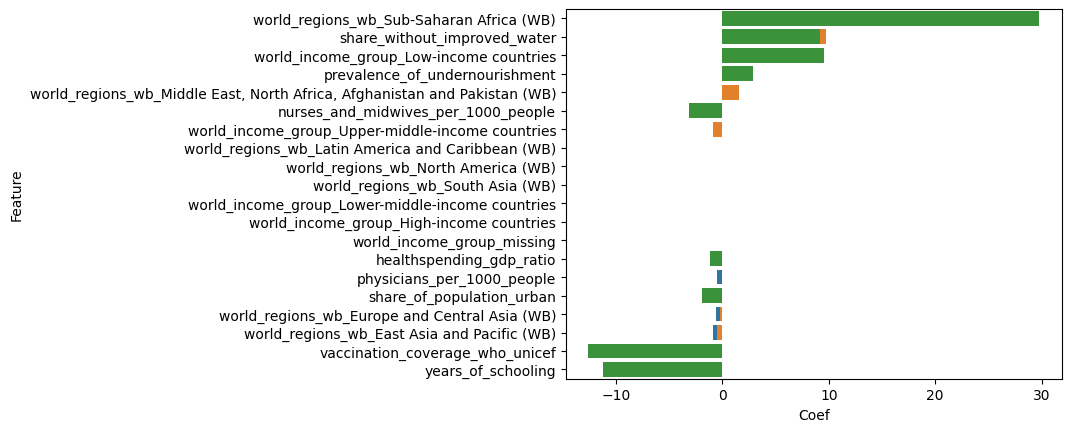

In [125]:
for q, model in qr_models.items():
    #qr_pipeline = model.regressor_
    qr_pipeline = model
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    #X_qr_transf = qr_pre.transform(X_train)
    X_qr_features = qr_pre.get_feature_names_out()
    qr_coeffs = qr_model.coef_
    coefs_df = pd.DataFrame({"Feature": X_qr_features, "Coef": qr_coeffs}).sort_values(by="Coef", ascending=False)
    print(f"Koeffizienten für Q{q}")
    print(coefs_df)
    sns.barplot(coefs_df, x=coefs_df["Coef"], y=coefs_df["Feature"])